In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense,Dropout,BatchNormalization, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('dataset_skripsi_clean_labeling_fix.csv',delimiter=';')
df

,Unnamed: 0,text,label
0,0,terimakasih tonton langsung lewat menit,Neutral
1,1,keren panji berani botak kritis apatis,Negative
2,2,prabowo masuk akal titik gagasanya muter,Positive
3,3,refleksi anies refleksi ganjar pranowo refleks...,Neutral
4,4,menit prabowo bilang aset mandek kuasa iya tol...,Neutral
...,...,...,...
17823,17965,kandidat ganjar pranowo calon presiden ideal p...,Neutral
17824,17966,tertawa data bps yohanes mnjabat tingkat miski...,Neutral
17825,17968,nampancoklat orang jawa tengah kadrun masuk ke...,Negative
17826,17969,prabowo halang urus rumah tanga beranta urus n...,Negative


In [3]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Unnamed: 0,text,label
0,0,terimakasih tonton langsung lewat menit,Neutral
1,1,keren panji berani botak kritis apatis,Negative
2,2,prabowo masuk akal titik gagasanya muter,Positive
3,3,refleksi anies refleksi ganjar pranowo refleks...,Neutral
4,4,menit prabowo bilang aset mandek kuasa iya tol...,Neutral
...,...,...,...
17823,17965,kandidat ganjar pranowo calon presiden ideal p...,Neutral
17824,17966,tertawa data bps yohanes mnjabat tingkat miski...,Neutral
17825,17968,nampancoklat orang jawa tengah kadrun masuk ke...,Negative
17826,17969,prabowo halang urus rumah tanga beranta urus n...,Negative


In [4]:
df['label'].value_counts()

label
Neutral     9047
Negative    4553
Positive    4228
Name: count, dtype: int64

In [5]:
import multiprocessing
from time import time
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("Total Core Computer : {} Core".format(cores))

Total Core Computer : 8 Core


In [6]:
from gensim.models import Word2Vec
tokenized_data = df['text'].apply(lambda x: x.split())  # tokenizing
model_w2v = Word2Vec(
    tokenized_data,
    vector_size=100,  # desired no. of features/independent variables
    window=5,  # context window size
    min_count=2,  # Ignores all words with total frequency lower than 2.
    sg=0,  # 1 for skip-gram model
    hs=0,
    negative=20,  # for negative sampling
    workers=cores - 4,  # no.of cores
    epochs=100
)
print(model_w2v)
print("Vocabulary Length:", len(model_w2v.wv.key_to_index))

Word2Vec<vocab=5458, vector_size=100, alpha=0.025>
Vocabulary Length: 5458


In [7]:
t = time()

model_w2v.build_vocab(tokenized_data, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [8]:
train_mw2v = model_w2v.train(tokenized_data, total_examples=len(df['text']), epochs=50, report_delay=1)
print(train_mw2v)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

(5523773, 7537000)
Time to build vocab: 0.17 mins


In [8]:
# Tokenize text data
max_len = 50
tokenizer = Tokenizer(num_words=len(model_w2v.wv.key_to_index))
tokenizer.fit_on_texts(df['text'])
text = tokenizer.texts_to_sequences(df['text'])
# Pad sequences
text = pad_sequences(text, maxlen=max_len, padding='post', truncating='post')

In [9]:
num_words = 50
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))  # Initialize with zeros
for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv.key_to_index:
        embedding_matrix[i] = model_w2v.wv[word]

In [10]:
X=df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])

In [11]:
import joblib

# Define the label encoder
label_encoder = encoder

# Save tokenizer, max_len, and label_encoder
joblib.dump(tokenizer, 'tokenizer.joblib')
joblib.dump(max_len, 'max_len.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [12]:
# Perform SMOTE oversampling on training data
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(text, y)

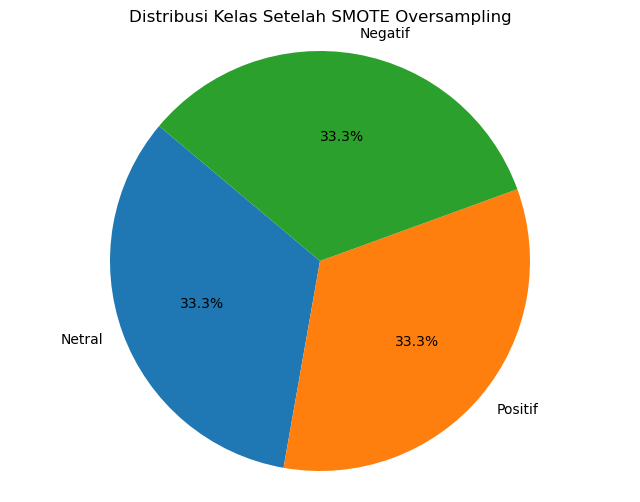

In [13]:
class_counts = pd.Series(y_train_smote).value_counts()

# Daftar label untuk klasifikasi (0=netral, 1=positif, 2=negatif)
labels = ['Netral', 'Positif', 'Negatif']

# Plot diagram lingkaran
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Kelas Setelah SMOTE Oversampling')
plt.axis('equal')  # Membuat diagram lingkaran menjadi lingkaran
plt.show()

In [14]:
pd.value_counts(y_train_smote)

C:\Users\ekaad\AppData\Local\Temp\ipykernel_17188\585918252.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train_smote)


1    9047
0    9047
2    9047
Name: count, dtype: int64

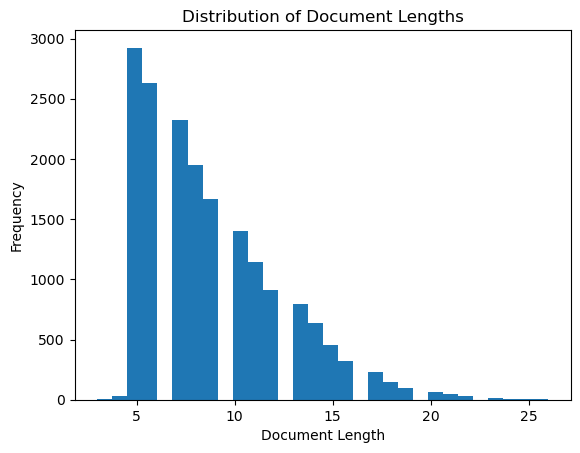

In [15]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
# Tokenize text to get lengths
tokenized_text = tokenizer.texts_to_sequences(df['text'])
lengths = [len(seq) for seq in tokenized_text]

# Plot the distribution
plt.hist(lengths, bins=30)
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [16]:
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

In [17]:
y_train = to_categorical(train_df['label'])
y_test = to_categorical(test_df['label'])

# CHECK VARIATIONS

In [ ]:
'''
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from graphviz import Digraph
from keras.preprocessing.sequence import pad_sequences

# Define your create_model function with learning_rate as an argument
def create_model():
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len,
                                weights=[embedding_matrix], trainable=False)(input_layer)
    conv_layer = Conv1D(128, 3, activation='relu')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dropout_layer = Dropout(0.5)(pooling_layer)
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Function to train and evaluate model for each fold
def train_and_evaluate_model(X_train, y_train, X_val, y_val, fold, previous_model=None):
    if previous_model is None:
        model = create_model()
    else:
        model = previous_model

    # Train model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=64, validation_data=(X_val, y_val))
    model.save(f"model_fold{fold}.h5")

    # Evaluate model
    y_pred = np.argmax(model.predict(X_val), axis=1)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    support = len(y_val)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    supports.append(support)

    print(f"Validation Accuracy: {accuracy}, Validation F1 Score: {f1}, Validation Precision: {precision}, Validation Recall: {recall}, Support: {support}")

    # Plot confusion matrix
    plot_confusion_matrix(y_val, y_pred, labels=[0, 1, 2])

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return model  # Return the trained model

# Main program
num_epochs_list = [10, 20, 50]  # Different numbers of epochs to try
test_size_list = [0.15, 0.2, 0.25]    # Different test sizes to try
val_size_list = [0.15, 0.2, 0.25]      # Different validation sizes to try

# Start Modeling
best_model_metrics = {
    'f1_score': 0,
    'precision': 0,
    'accuracy': 0,
    'recall': 0,
    'support': 0,
    'model': None,
    'epoch': 0
}

for num_epochs in num_epochs_list:
    for test_size in test_size_list:
        for val_size in val_size_list:
            print(f"Number of Epochs: {num_epochs}, Test Size: {test_size}, Validation Size: {val_size}")
            accuracy_scores = []
            f1_scores = []
            precisions = []
            recalls = []
            supports = []

            kfold = KFold(n_splits=8, shuffle=True, random_state=42)
            # Iterate over each fold
            final_models = []  # List to store final models for each fold
            previous_model = None
            for fold, (train_indices, val_indices) in enumerate(kfold.split(text, y), 1):
                print(f'Fold {fold}')

                X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=test_size, random_state=42)
                X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=val_size/(1-test_size), random_state=42)

                final_model = train_and_evaluate_model(X_train, y_train, X_val, y_val, fold, previous_model)
                final_models.append(final_model)  # Append the final model for this fold
                previous_model = final_model  # Set current model as previous model for next fold

            # Save final models for each fold
            for fold, model in enumerate(final_models, 1):
                model.save(f"final_model_variation_epochs_{num_epochs}_test_size_{test_size}_val_size_{val_size}_fold_{fold}.h5")

            # Compare with best model so far
                if f1 > best_model_metrics['f1_score'] or \
                  (f1 == best_model_metrics['f1_score'] and accuracy > best_model_metrics['accuracy']) or \
                  (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                  precision > best_model_metrics['precision']) or \
                  (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                  precision == best_model_metrics['precision'] and recall > best_model_metrics['recall']) or \
                  (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                  precision == best_model_metrics['precision'] and recall == best_model_metrics['recall'] and
                  support > best_model_metrics['support']):
              best_model_metrics['f1_score'] = f1
              best_model_metrics['precision'] = precision
              best_model_metrics['accuracy'] = accuracy
              best_model_metrics['recall'] = recall
              best_model_metrics['support'] = support
              best_model_metrics['model'] = model
              best_model_metrics['epoch'] = epoch

        print(f'Best Model Metrics for Epoch {epoch}:')
        print(best_model_metrics)

# Save the best model
best_model_metrics['model'].save(f"best_model_epoch_{best_model_metrics['epoch']}.h5")
print(f'Best model saved as: best_model_epoch_{best_model_metrics["epoch"]}.h5')

'\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.model_selection import KFold, train_test_split\nfrom sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score\nimport tensorflow as tf\nfrom tensorflow.keras.models import load_model, Model\nfrom tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout\nfrom graphviz import Digraph\nfrom keras.preprocessing.sequence import pad_sequences\n\n# Define your create_model function with learning_rate as an argument\ndef create_model():\n    input_layer = Input(shape=(max_len,))\n    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len,\n                                weights=[embedding_matrix], trainable=False)(input_layer)\n    conv_layer = Conv1D(128, 3, activation=\'relu\')(embedding_layer)\n    pooling_layer = GlobalMaxPooling1D()(conv_layer)\n    dropout_layer = Dropout(



Epochs: 10
Fold 1
Epoch 1/10


223/223 [==============================] - 3s 7ms/step - loss: 1.6859 - accuracy: 0.4954 - val_loss: 0.8249 - val_accuracy: 0.6371
Epoch 2/10
223/223 [==============================] - 1s 6ms/step - loss: 0.9835 - accuracy: 0.5937 - val_loss: 0.7726 - val_accuracy: 0.6573
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.8432 - accuracy: 0.6278 - val_loss: 0.7561 - val_accuracy: 0.6713
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.7782 - accuracy: 0.6556 - val_loss: 0.7473 - val_accuracy: 0.6739
Epoch 5/10
223/223 [==============================] - 1s 6ms/step - loss: 0.7478 - accuracy: 0.6709 - val_loss: 0.7318 - val_accuracy: 0.6856
Epoch 6/10
223/223 [==============================] - 1s 6ms/step - loss: 0.7220 - accuracy: 0.6844 - val_loss: 0.7296 - val_accuracy: 0.6876
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.7027 - accuracy: 0.6920 - val_loss: 0.7161 - val_a

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7019068984856983, Validation F1 Score: 0.6963769732409177, Validation Precision: 0.69867344342011, Validation Recall: 0.7019068984856983
              precision    recall  f1-score   support

    Positive       0.66      0.53      0.59       877
    Negative       0.72      0.82      0.76      1866
     Neutral       0.70      0.62      0.66       823

    accuracy                           0.70      3566
   macro avg       0.69      0.66      0.67      3566
weighted avg       0.70      0.70      0.70      3566



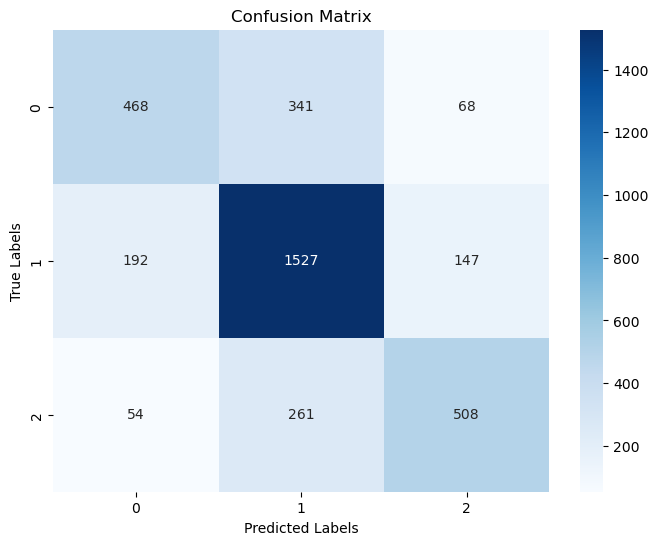

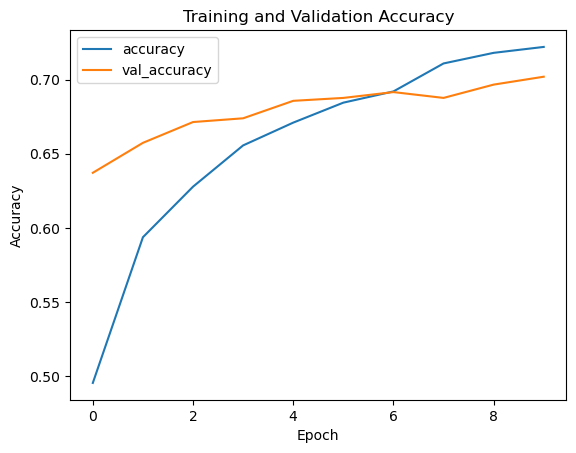

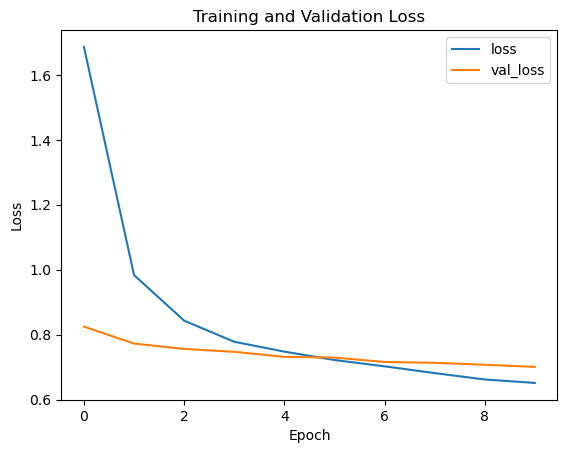

Fold 2
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.6661 - accuracy: 0.7166 - val_loss: 0.5637 - val_accuracy: 0.7723
Epoch 2/10
223/223 [==============================] - 1s 6ms/step - loss: 0.6465 - accuracy: 0.7266 - val_loss: 0.5801 - val_accuracy: 0.7608
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.6218 - accuracy: 0.7350 - val_loss: 0.5912 - val_accuracy: 0.7535
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.6073 - accuracy: 0.7469 - val_loss: 0.5941 - val_accuracy: 0.7462
Epoch 5/10
223/223 [==============================] - 1s 7ms/step - loss: 0.6023 - accuracy: 0.7502 - val_loss: 0.5996 - val_accuracy: 0.7448
Epoch 6/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5844 - accuracy: 0.7580 - val_loss: 0.6030 - val_accuracy: 0.7459
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5769 - accuracy: 0.7618 - val_loss: 0.6187 - val_accuracy: 0.7308

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7305103757711722, Validation F1 Score: 0.7253143092859096, Validation Precision: 0.7339163573933742, Validation Recall: 0.7305103757711722
              precision    recall  f1-score   support

    Positive       0.72      0.58      0.64       920
    Negative       0.72      0.86      0.78      1761
     Neutral       0.79      0.63      0.70       885

    accuracy                           0.73      3566
   macro avg       0.74      0.69      0.71      3566
weighted avg       0.73      0.73      0.73      3566



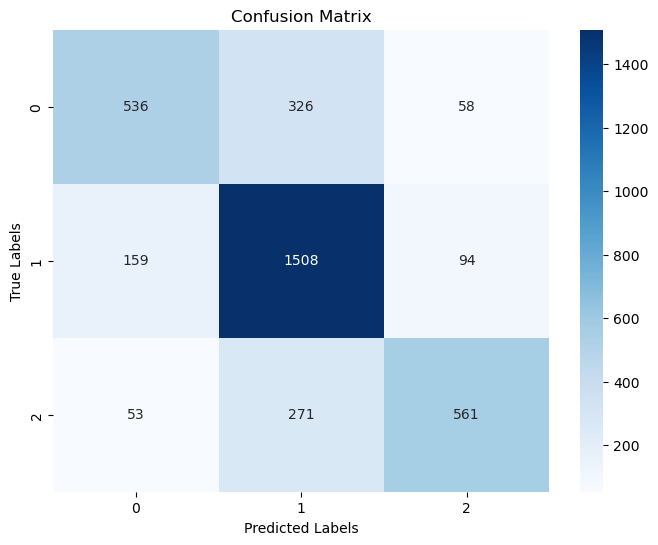

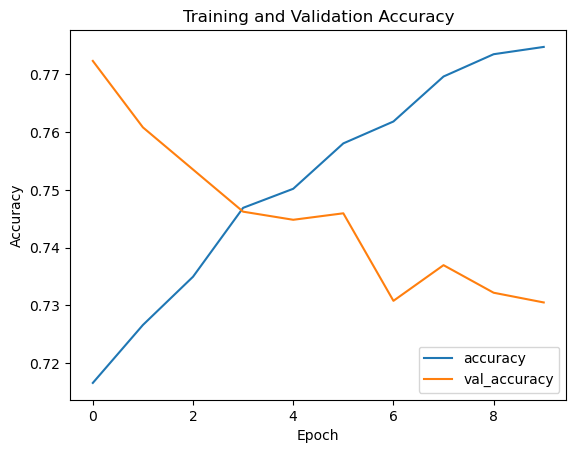

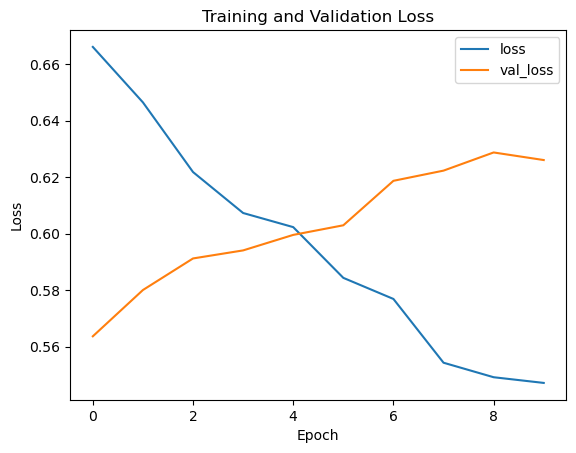

Fold 3
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.5857 - accuracy: 0.7582 - val_loss: 0.4216 - val_accuracy: 0.8432
Epoch 2/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5613 - accuracy: 0.7692 - val_loss: 0.4472 - val_accuracy: 0.8289
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5464 - accuracy: 0.7730 - val_loss: 0.4607 - val_accuracy: 0.8200
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5384 - accuracy: 0.7792 - val_loss: 0.4864 - val_accuracy: 0.8102
Epoch 5/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5151 - accuracy: 0.7905 - val_loss: 0.4883 - val_accuracy: 0.8015
Epoch 6/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5100 - accuracy: 0.7920 - val_loss: 0.5011 - val_accuracy: 0.7908
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5060 - accuracy: 0.7947 - val_loss: 0.4999 - val_accuracy: 0.7936

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.784913067863152, Validation F1 Score: 0.7818529580073722, Validation Precision: 0.786332178514978, Validation Recall: 0.784913067863152
              precision    recall  f1-score   support

    Positive       0.78      0.65      0.71       932
    Negative       0.77      0.88      0.82      1806
     Neutral       0.82      0.73      0.77       828

    accuracy                           0.78      3566
   macro avg       0.79      0.75      0.77      3566
weighted avg       0.79      0.78      0.78      3566



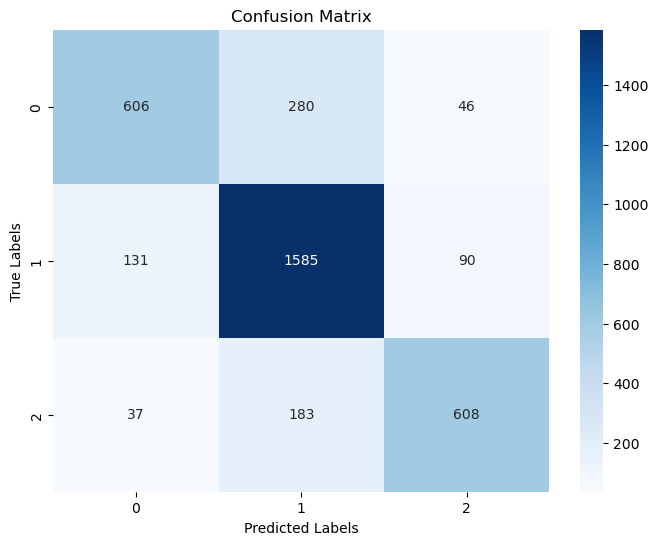

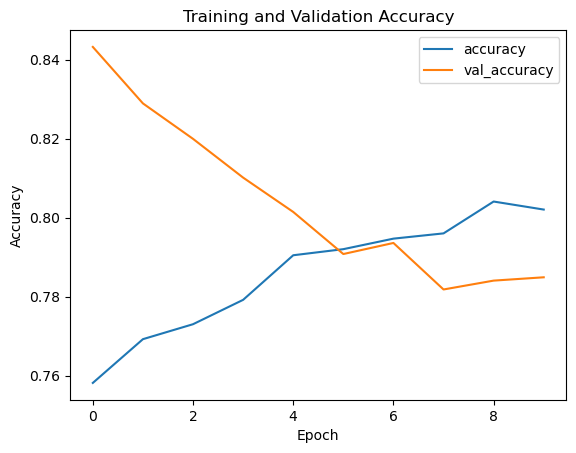

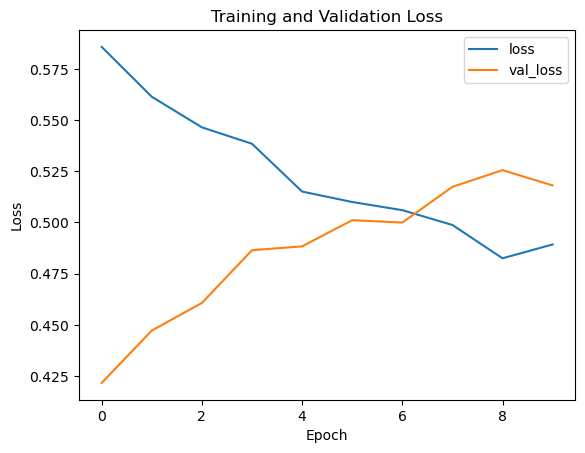

Fold 4
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.5278 - accuracy: 0.7842 - val_loss: 0.3239 - val_accuracy: 0.8884
Epoch 2/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5075 - accuracy: 0.7960 - val_loss: 0.3539 - val_accuracy: 0.8701
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4940 - accuracy: 0.7991 - val_loss: 0.3710 - val_accuracy: 0.8583
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4839 - accuracy: 0.7998 - val_loss: 0.3805 - val_accuracy: 0.8519
Epoch 5/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4678 - accuracy: 0.8096 - val_loss: 0.3963 - val_accuracy: 0.8393
Epoch 6/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4613 - accuracy: 0.8163 - val_loss: 0.4099 - val_accuracy: 0.8306
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4567 - accuracy: 0.8139 - val_loss: 0.4222 - val_accuracy: 0.8247

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8137447405329593, Validation F1 Score: 0.8111740811077363, Validation Precision: 0.8159310642810985, Validation Recall: 0.8137447405329593
              precision    recall  f1-score   support

    Positive       0.82      0.68      0.74       898
    Negative       0.80      0.90      0.84      1814
     Neutral       0.85      0.78      0.81       853

    accuracy                           0.81      3565
   macro avg       0.82      0.78      0.80      3565
weighted avg       0.82      0.81      0.81      3565



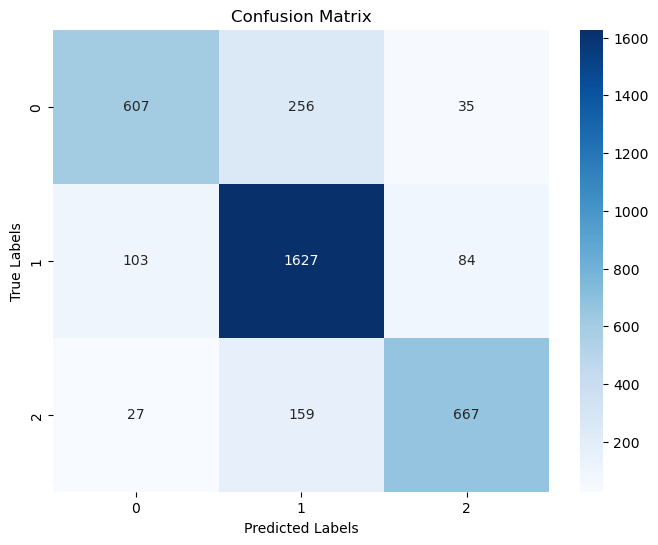

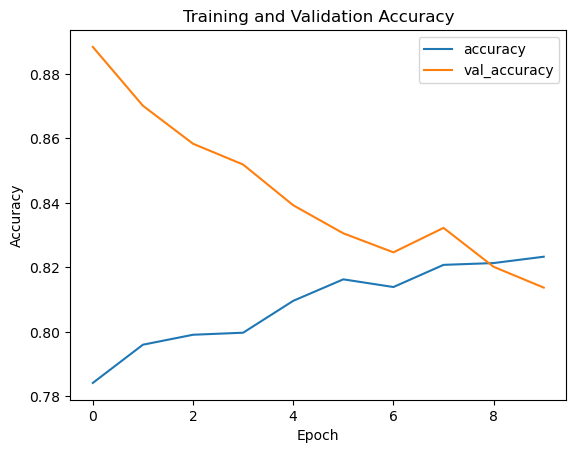

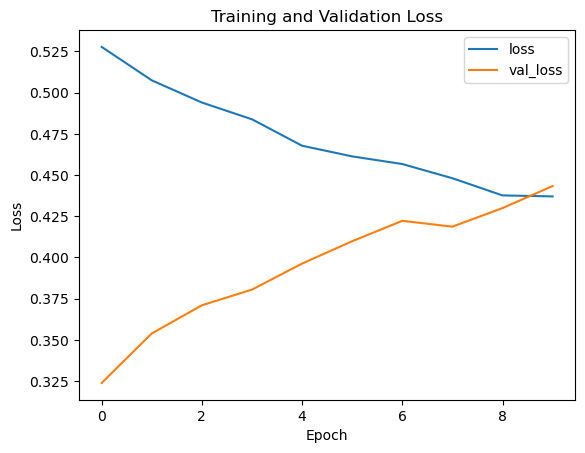

Fold 5
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4831 - accuracy: 0.8028 - val_loss: 0.2852 - val_accuracy: 0.9041
Epoch 2/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4577 - accuracy: 0.8157 - val_loss: 0.3120 - val_accuracy: 0.8870
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4561 - accuracy: 0.8147 - val_loss: 0.3311 - val_accuracy: 0.8805
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4405 - accuracy: 0.8248 - val_loss: 0.3411 - val_accuracy: 0.8659
Epoch 5/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4282 - accuracy: 0.8297 - val_loss: 0.3543 - val_accuracy: 0.8597
Epoch 6/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4208 - accuracy: 0.8315 - val_loss: 0.3645 - val_accuracy: 0.8491
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4207 - accuracy: 0.8317 - val_loss: 0.3787 - val_accuracy: 0.8474

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8373071528751753, Validation F1 Score: 0.8366207239909693, Validation Precision: 0.8397909150544027, Validation Recall: 0.8373071528751753
              precision    recall  f1-score   support

    Positive       0.81      0.78      0.80       926
    Negative       0.82      0.89      0.86      1800
     Neutral       0.90      0.78      0.83       839

    accuracy                           0.84      3565
   macro avg       0.85      0.82      0.83      3565
weighted avg       0.84      0.84      0.84      3565



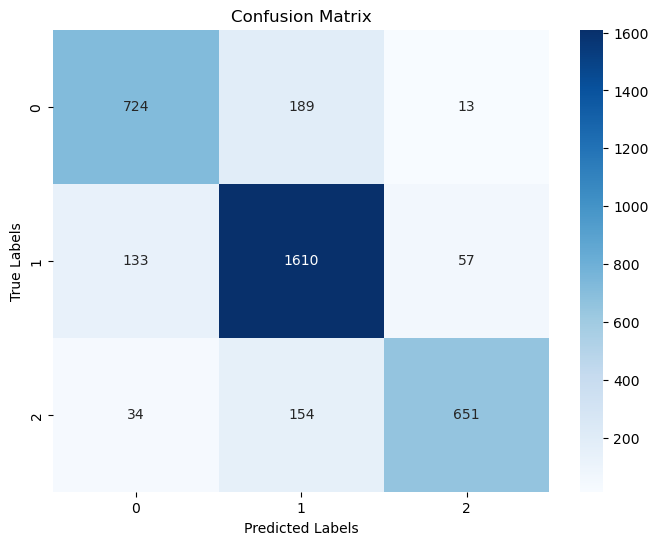

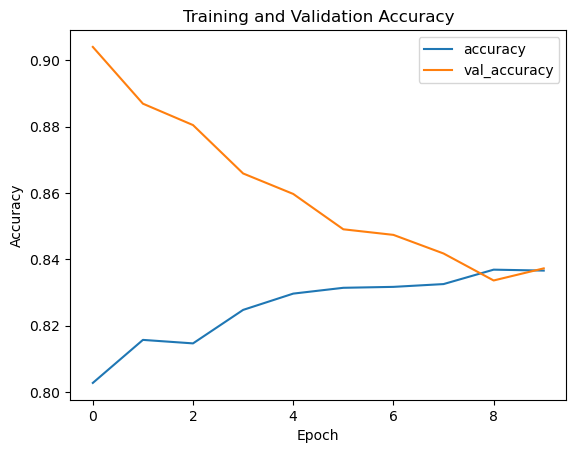

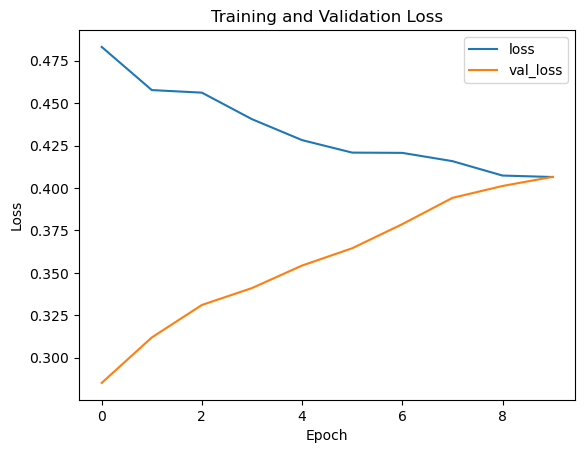

Mean Accuracy: 0.7736764471056314
Mean F1 Score: 0.7702678091265811

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.66      0.53      0.59       877
    Negative       0.72      0.82      0.76      1866
     Neutral       0.70      0.62      0.66       823

    accuracy                           0.70      3566
   macro avg       0.69      0.66      0.67      3566
weighted avg       0.70      0.70      0.70      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.72      0.58      0.64       920
    Negative       0.72      0.86      0.78      1761
     Neutral       0.79      0.63      0.70       885

    accuracy                           0.73      3566
   macro avg       0.74      0.69      0.71      3566
weighted avg       0.73      0.73      0.73      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.7

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.709478407178912, Validation F1 Score: 0.7039786779939396, Validation Precision: 0.7064229910265856, Validation Recall: 0.709478407178912
              precision    recall  f1-score   support

    Positive       0.67      0.54      0.60       877
    Negative       0.72      0.83      0.77      1866
     Neutral       0.71      0.62      0.66       823

    accuracy                           0.71      3566
   macro avg       0.70      0.66      0.68      3566
weighted avg       0.71      0.71      0.70      3566



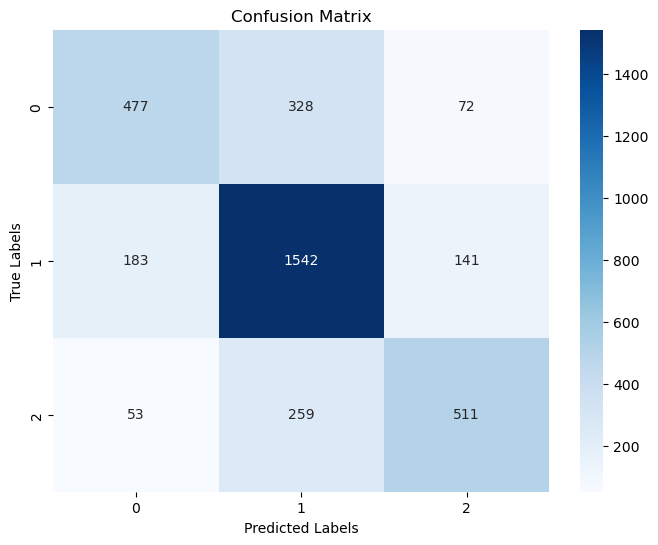

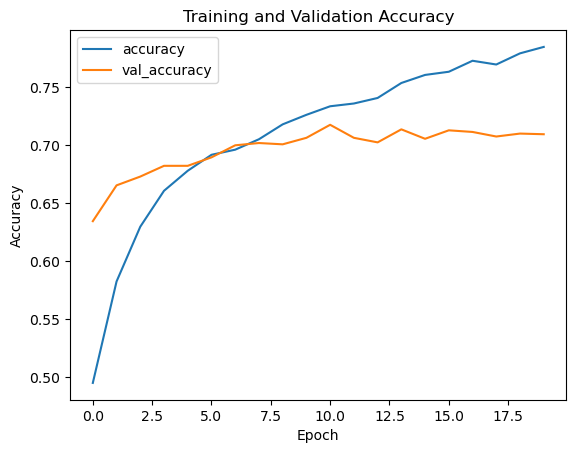

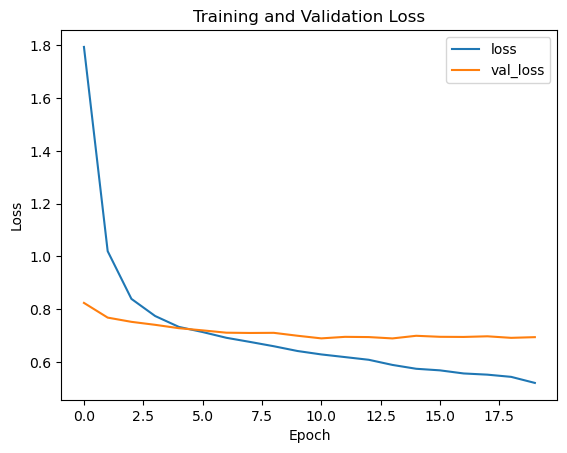

Fold 2
Epoch 1/20
223/223 [==============================] - 2s 8ms/step - loss: 0.5918 - accuracy: 0.7624 - val_loss: 0.4375 - val_accuracy: 0.8390
Epoch 2/20
223/223 [==============================] - 1s 6ms/step - loss: 0.5597 - accuracy: 0.7742 - val_loss: 0.4642 - val_accuracy: 0.8102
Epoch 3/20
223/223 [==============================] - 1s 7ms/step - loss: 0.5570 - accuracy: 0.7734 - val_loss: 0.4736 - val_accuracy: 0.8155
Epoch 4/20
223/223 [==============================] - 1s 7ms/step - loss: 0.5314 - accuracy: 0.7807 - val_loss: 0.4934 - val_accuracy: 0.8009
Epoch 5/20
223/223 [==============================] - 1s 7ms/step - loss: 0.5196 - accuracy: 0.7889 - val_loss: 0.4957 - val_accuracy: 0.8031
Epoch 6/20
223/223 [==============================] - 1s 6ms/step - loss: 0.5146 - accuracy: 0.7847 - val_loss: 0.5173 - val_accuracy: 0.7824
Epoch 7/20
223/223 [==============================] - 1s 6ms/step - loss: 0.5032 - accuracy: 0.7939 - val_loss: 0.5160 - val_accuracy: 0.7902

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7515423443634324, Validation F1 Score: 0.7455721576664436, Validation Precision: 0.7564019684816061, Validation Recall: 0.7515423443634324
              precision    recall  f1-score   support

    Positive       0.76      0.57      0.65       920
    Negative       0.73      0.88      0.80      1761
     Neutral       0.81      0.67      0.74       885

    accuracy                           0.75      3566
   macro avg       0.77      0.71      0.73      3566
weighted avg       0.76      0.75      0.75      3566



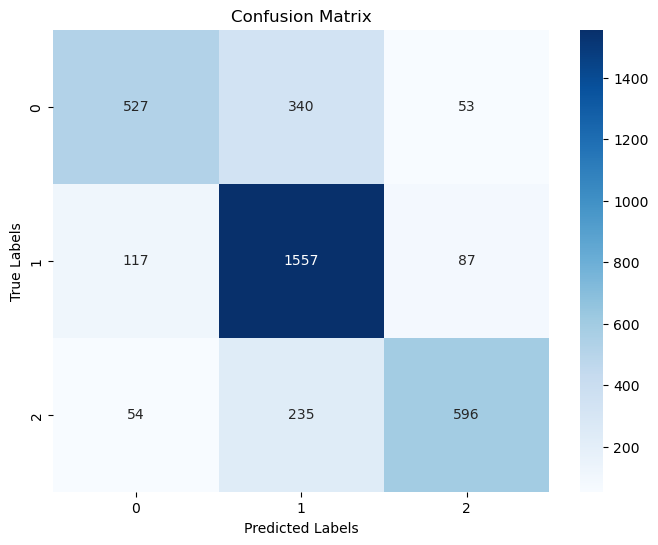

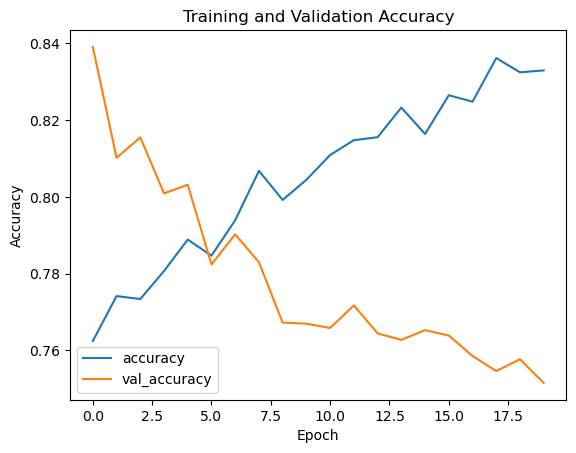

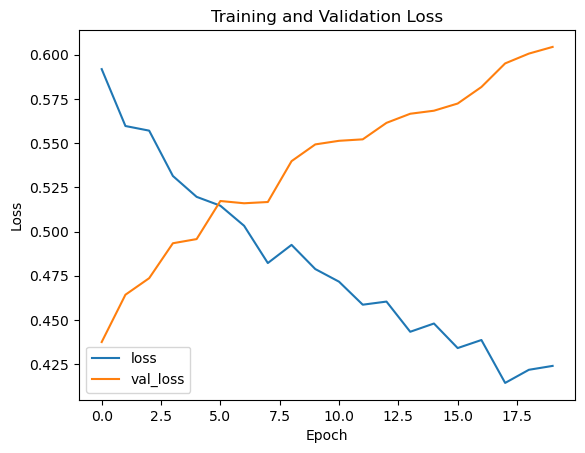

Fold 3
Epoch 1/20
223/223 [==============================] - 2s 8ms/step - loss: 0.5030 - accuracy: 0.8046 - val_loss: 0.2794 - val_accuracy: 0.9139
Epoch 2/20
223/223 [==============================] - 1s 7ms/step - loss: 0.4829 - accuracy: 0.8038 - val_loss: 0.3146 - val_accuracy: 0.8962
Epoch 3/20
223/223 [==============================] - 2s 7ms/step - loss: 0.4584 - accuracy: 0.8177 - val_loss: 0.3283 - val_accuracy: 0.8797
Epoch 4/20
223/223 [==============================] - 2s 7ms/step - loss: 0.4508 - accuracy: 0.8168 - val_loss: 0.3375 - val_accuracy: 0.8744
Epoch 5/20
223/223 [==============================] - 1s 7ms/step - loss: 0.4385 - accuracy: 0.8239 - val_loss: 0.3592 - val_accuracy: 0.8651
Epoch 6/20
223/223 [==============================] - 2s 7ms/step - loss: 0.4331 - accuracy: 0.8289 - val_loss: 0.3626 - val_accuracy: 0.8598
Epoch 7/20
223/223 [==============================] - 2s 8ms/step - loss: 0.4253 - accuracy: 0.8301 - val_loss: 0.3778 - val_accuracy: 0.8505

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8028603477285474, Validation F1 Score: 0.799908128655427, Validation Precision: 0.8048505381447326, Validation Recall: 0.8028603477285474
              precision    recall  f1-score   support

    Positive       0.81      0.66      0.73       932
    Negative       0.79      0.89      0.84      1806
     Neutral       0.84      0.76      0.80       828

    accuracy                           0.80      3566
   macro avg       0.81      0.77      0.79      3566
weighted avg       0.80      0.80      0.80      3566



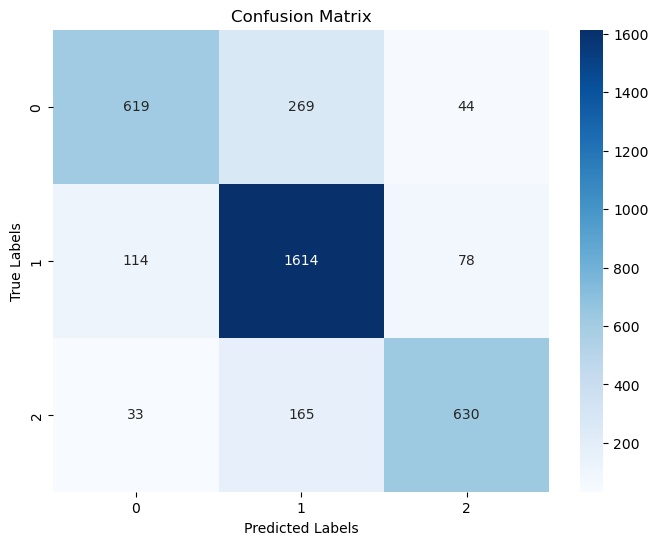

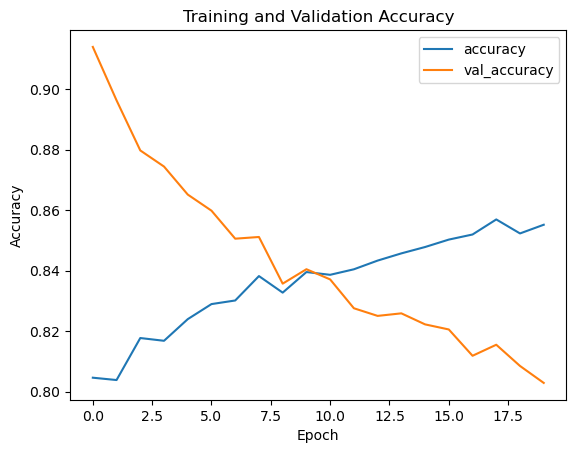

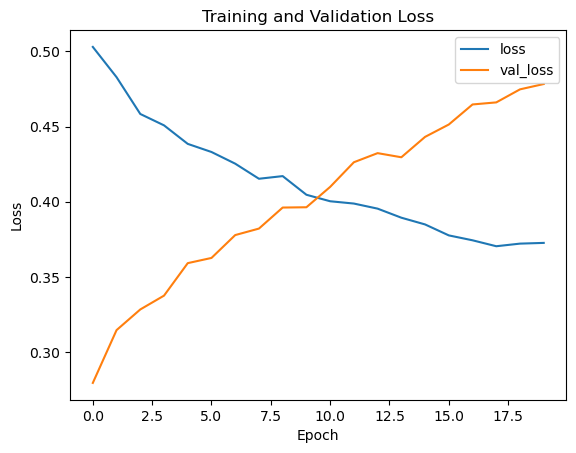

Fold 4
Epoch 1/20
223/223 [==============================] - 2s 8ms/step - loss: 0.4527 - accuracy: 0.8235 - val_loss: 0.2081 - val_accuracy: 0.9411
Epoch 2/20
223/223 [==============================] - 2s 7ms/step - loss: 0.4272 - accuracy: 0.8329 - val_loss: 0.2221 - val_accuracy: 0.9394
Epoch 3/20
223/223 [==============================] - 1s 6ms/step - loss: 0.4069 - accuracy: 0.8395 - val_loss: 0.2441 - val_accuracy: 0.9189
Epoch 4/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3901 - accuracy: 0.8476 - val_loss: 0.2546 - val_accuracy: 0.9086
Epoch 5/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3940 - accuracy: 0.8388 - val_loss: 0.2640 - val_accuracy: 0.9046
Epoch 6/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3746 - accuracy: 0.8496 - val_loss: 0.2840 - val_accuracy: 0.8878
Epoch 7/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3702 - accuracy: 0.8540 - val_loss: 0.2832 - val_accuracy: 0.8948

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8364656381486676, Validation F1 Score: 0.8335734723226592, Validation Precision: 0.8405078558734951, Validation Recall: 0.8364656381486676
              precision    recall  f1-score   support

    Positive       0.86      0.68      0.76       898
    Negative       0.81      0.93      0.87      1814
     Neutral       0.88      0.80      0.84       853

    accuracy                           0.84      3565
   macro avg       0.85      0.81      0.82      3565
weighted avg       0.84      0.84      0.83      3565



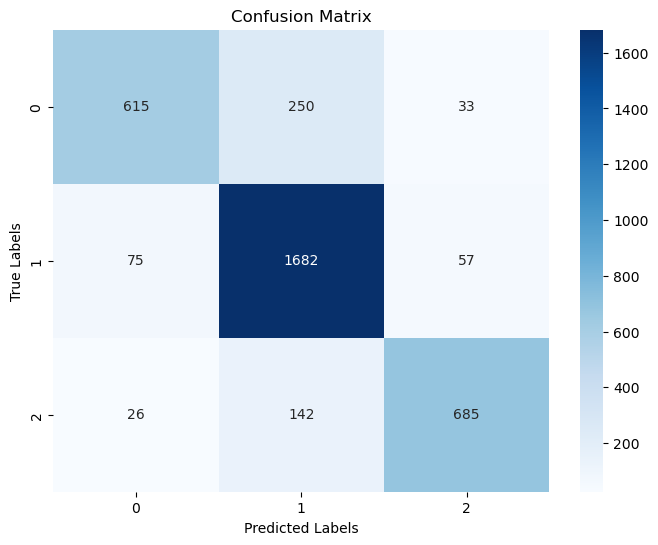

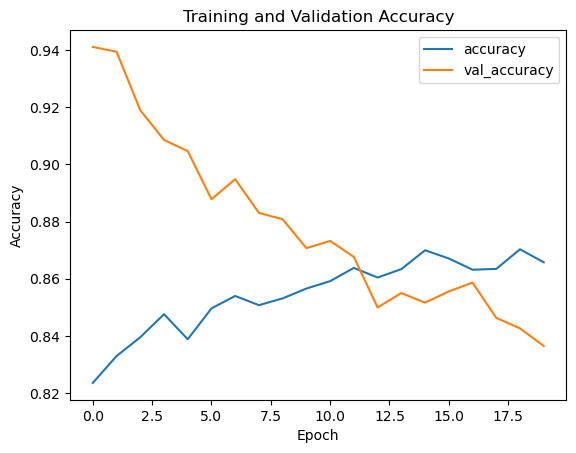

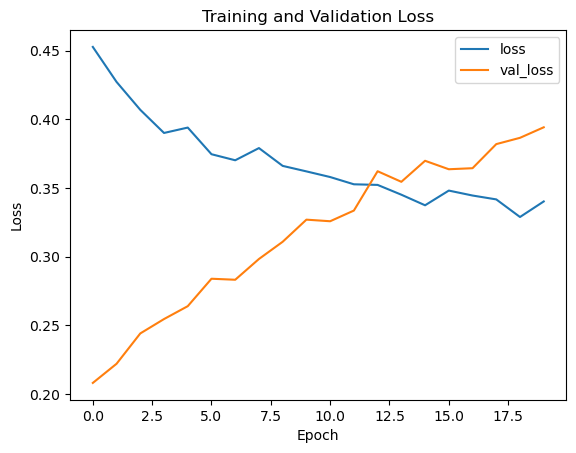

Fold 5
Epoch 1/20
223/223 [==============================] - 2s 7ms/step - loss: 0.4098 - accuracy: 0.8441 - val_loss: 0.1820 - val_accuracy: 0.9453
Epoch 2/20
223/223 [==============================] - 1s 7ms/step - loss: 0.3770 - accuracy: 0.8536 - val_loss: 0.1945 - val_accuracy: 0.9431
Epoch 3/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3622 - accuracy: 0.8615 - val_loss: 0.2157 - val_accuracy: 0.9282
Epoch 4/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3551 - accuracy: 0.8587 - val_loss: 0.2242 - val_accuracy: 0.9259
Epoch 5/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3478 - accuracy: 0.8639 - val_loss: 0.2395 - val_accuracy: 0.9102
Epoch 6/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3366 - accuracy: 0.8682 - val_loss: 0.2496 - val_accuracy: 0.9038
Epoch 7/20
223/223 [==============================] - 1s 6ms/step - loss: 0.3435 - accuracy: 0.8662 - val_loss: 0.2540 - val_accuracy: 0.8999

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8532959326788219, Validation F1 Score: 0.8520846240840951, Validation Precision: 0.8554593079469972, Validation Recall: 0.8532959326788219
              precision    recall  f1-score   support

    Positive       0.88      0.77      0.82       926
    Negative       0.84      0.92      0.87      1800
     Neutral       0.87      0.81      0.84       839

    accuracy                           0.85      3565
   macro avg       0.86      0.83      0.84      3565
weighted avg       0.86      0.85      0.85      3565



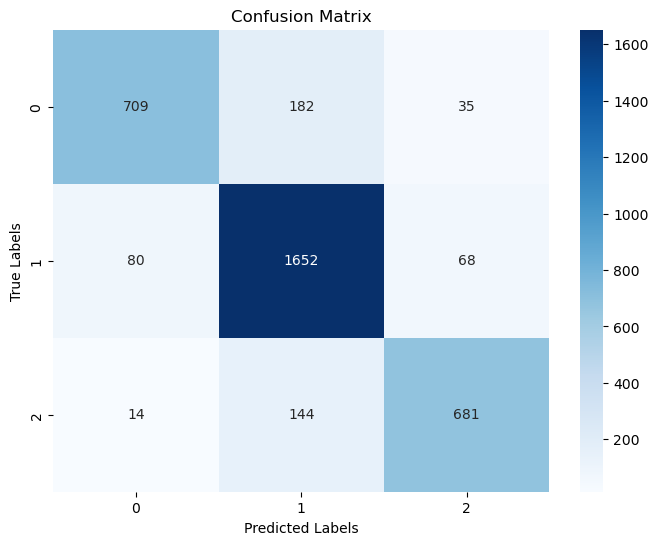

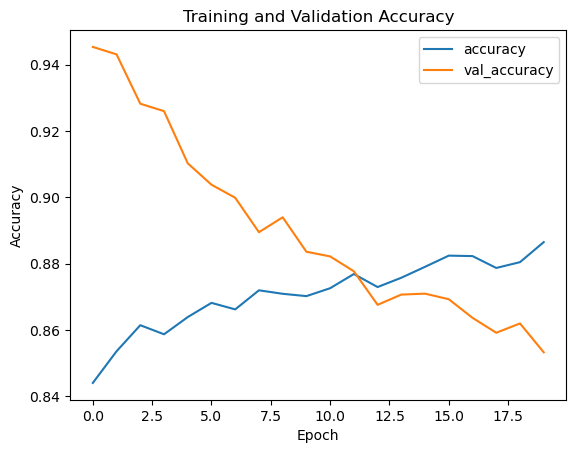

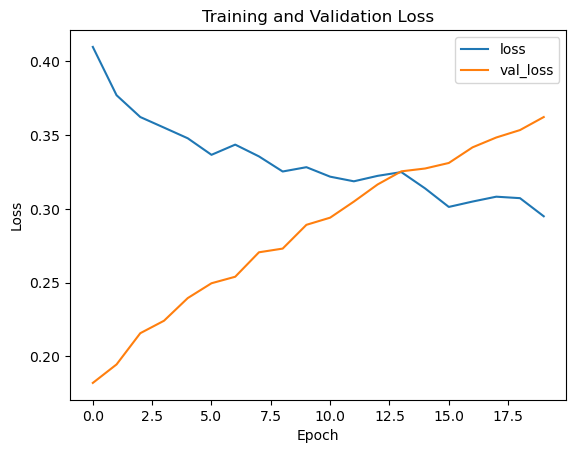

Mean Accuracy: 0.7907285340196762
Mean F1 Score: 0.7870234121445129

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.67      0.54      0.60       877
    Negative       0.72      0.83      0.77      1866
     Neutral       0.71      0.62      0.66       823

    accuracy                           0.71      3566
   macro avg       0.70      0.66      0.68      3566
weighted avg       0.71      0.71      0.70      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.76      0.57      0.65       920
    Negative       0.73      0.88      0.80      1761
     Neutral       0.81      0.67      0.74       885

    accuracy                           0.75      3566
   macro avg       0.77      0.71      0.73      3566
weighted avg       0.76      0.75      0.75      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7055524397083567, Validation F1 Score: 0.6992981386069295, Validation Precision: 0.7026283054005593, Validation Recall: 0.7055524397083567
              precision    recall  f1-score   support

    Positive       0.67      0.51      0.58       877
    Negative       0.72      0.82      0.77      1866
     Neutral       0.70      0.65      0.68       823

    accuracy                           0.71      3566
   macro avg       0.70      0.66      0.67      3566
weighted avg       0.70      0.71      0.70      3566



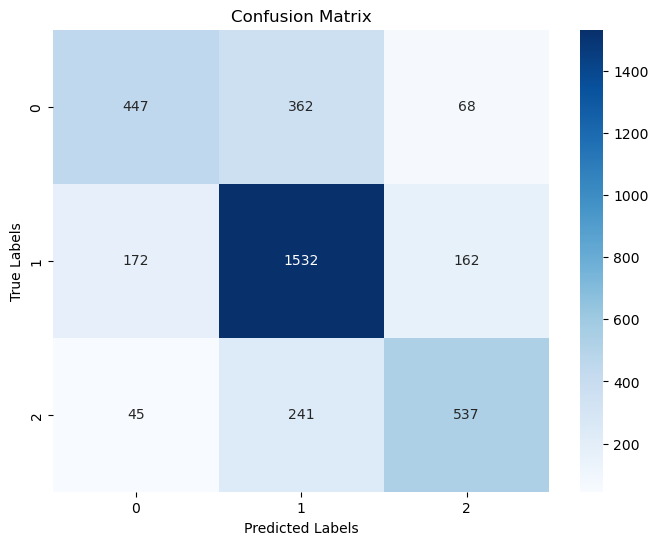

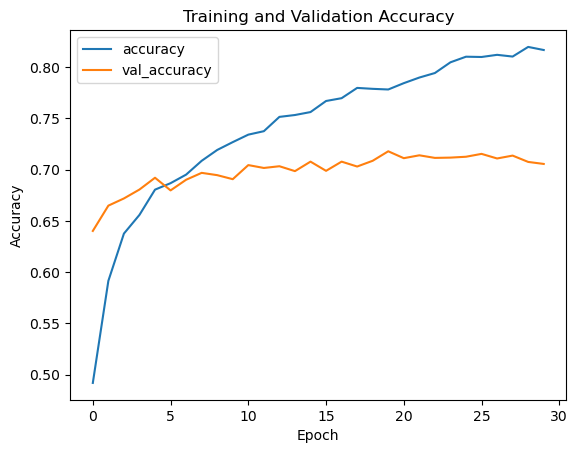

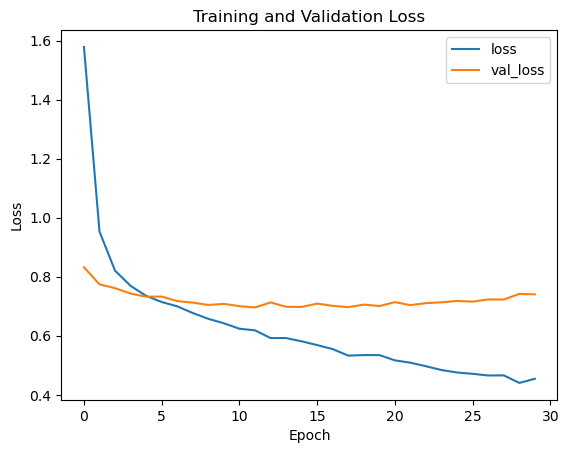

Fold 2
Epoch 1/30
223/223 [==============================] - 2s 7ms/step - loss: 0.5606 - accuracy: 0.7788 - val_loss: 0.3452 - val_accuracy: 0.8864
Epoch 2/30
223/223 [==============================] - 1s 6ms/step - loss: 0.5212 - accuracy: 0.7866 - val_loss: 0.3773 - val_accuracy: 0.8615
Epoch 3/30
223/223 [==============================] - 1s 7ms/step - loss: 0.4999 - accuracy: 0.8011 - val_loss: 0.3916 - val_accuracy: 0.8511
Epoch 4/30
223/223 [==============================] - 2s 7ms/step - loss: 0.4923 - accuracy: 0.8027 - val_loss: 0.4095 - val_accuracy: 0.8483
Epoch 5/30
223/223 [==============================] - 1s 6ms/step - loss: 0.4681 - accuracy: 0.8138 - val_loss: 0.4125 - val_accuracy: 0.8390
Epoch 6/30
223/223 [==============================] - 2s 7ms/step - loss: 0.4701 - accuracy: 0.8114 - val_loss: 0.4281 - val_accuracy: 0.8337
Epoch 7/30
223/223 [==============================] - 1s 6ms/step - loss: 0.4587 - accuracy: 0.8195 - val_loss: 0.4390 - val_accuracy: 0.8284

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7602355580482333, Validation F1 Score: 0.7560797958295757, Validation Precision: 0.7635141211714561, Validation Recall: 0.7602355580482333
              precision    recall  f1-score   support

    Positive       0.77      0.61      0.68       920
    Negative       0.74      0.87      0.80      1761
     Neutral       0.80      0.69      0.74       885

    accuracy                           0.76      3566
   macro avg       0.77      0.73      0.74      3566
weighted avg       0.76      0.76      0.76      3566



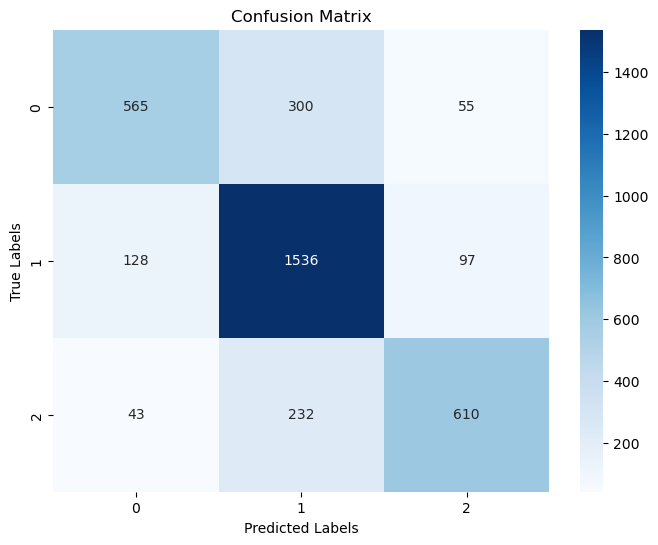

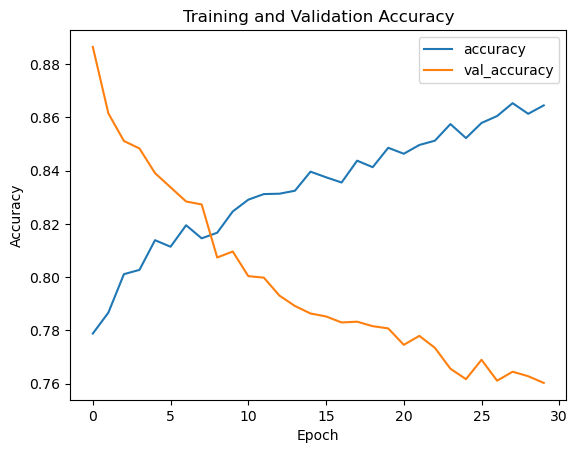

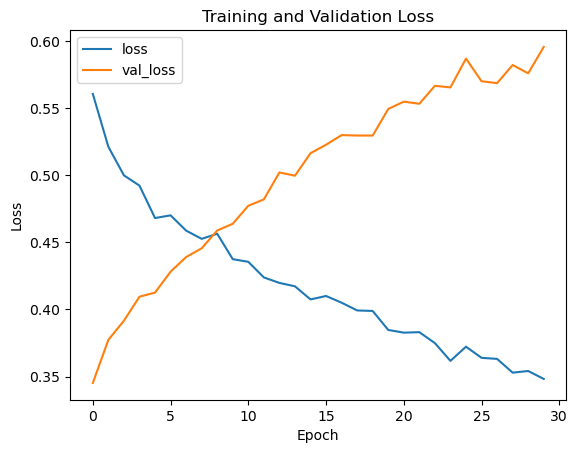

Fold 3
Epoch 1/30
223/223 [==============================] - 2s 7ms/step - loss: 0.4762 - accuracy: 0.8192 - val_loss: 0.2174 - val_accuracy: 0.9383
Epoch 2/30
223/223 [==============================] - 1s 6ms/step - loss: 0.4421 - accuracy: 0.8272 - val_loss: 0.2396 - val_accuracy: 0.9226
Epoch 3/30
223/223 [==============================] - 2s 7ms/step - loss: 0.4084 - accuracy: 0.8380 - val_loss: 0.2535 - val_accuracy: 0.9145
Epoch 4/30
223/223 [==============================] - 1s 6ms/step - loss: 0.4005 - accuracy: 0.8407 - val_loss: 0.2715 - val_accuracy: 0.9007
Epoch 5/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3996 - accuracy: 0.8426 - val_loss: 0.2799 - val_accuracy: 0.9010
Epoch 6/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3922 - accuracy: 0.8454 - val_loss: 0.3008 - val_accuracy: 0.8884
Epoch 7/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3787 - accuracy: 0.8520 - val_loss: 0.3067 - val_accuracy: 0.8817

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8166012338754908, Validation F1 Score: 0.8139843779314443, Validation Precision: 0.8199494524703465, Validation Recall: 0.8166012338754908
              precision    recall  f1-score   support

    Positive       0.83      0.69      0.75       932
    Negative       0.80      0.91      0.85      1806
     Neutral       0.87      0.75      0.81       828

    accuracy                           0.82      3566
   macro avg       0.83      0.79      0.80      3566
weighted avg       0.82      0.82      0.81      3566



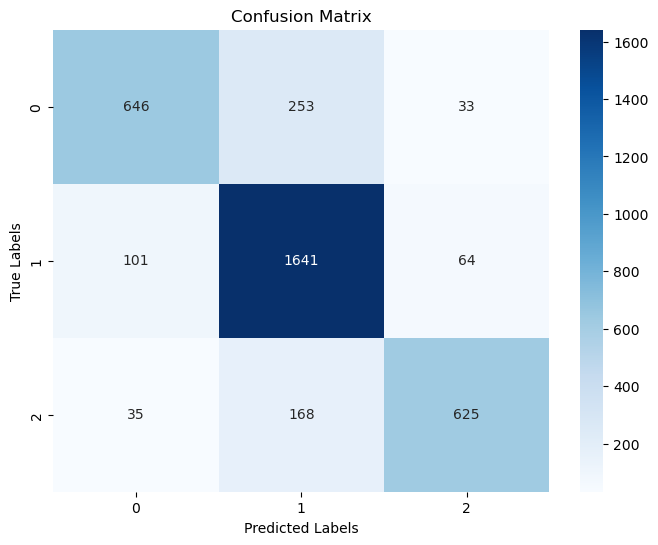

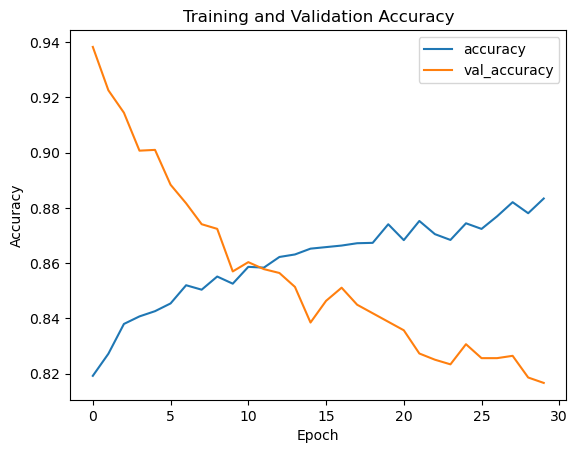

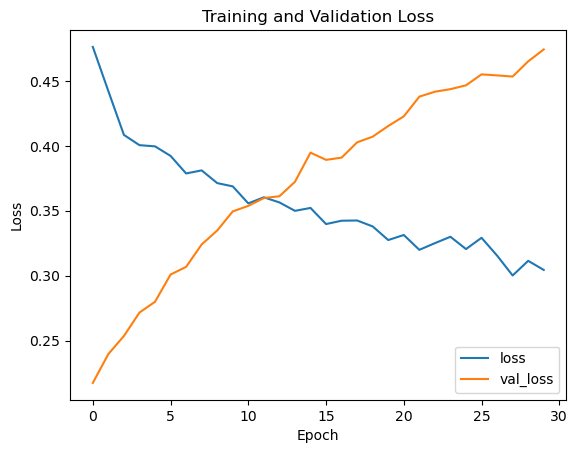

Fold 4
Epoch 1/30
223/223 [==============================] - 2s 7ms/step - loss: 0.4100 - accuracy: 0.8466 - val_loss: 0.1509 - val_accuracy: 0.9607
Epoch 2/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3872 - accuracy: 0.8505 - val_loss: 0.1662 - val_accuracy: 0.9560
Epoch 3/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3747 - accuracy: 0.8550 - val_loss: 0.1821 - val_accuracy: 0.9456
Epoch 4/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3706 - accuracy: 0.8551 - val_loss: 0.1956 - val_accuracy: 0.9414
Epoch 5/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3469 - accuracy: 0.8645 - val_loss: 0.2004 - val_accuracy: 0.9335
Epoch 6/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3441 - accuracy: 0.8648 - val_loss: 0.2086 - val_accuracy: 0.9288
Epoch 7/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3391 - accuracy: 0.8668 - val_loss: 0.2268 - val_accuracy: 0.9206

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8460028050490883, Validation F1 Score: 0.8449455427153681, Validation Precision: 0.8468612784253865, Validation Recall: 0.8460028050490883
              precision    recall  f1-score   support

    Positive       0.86      0.75      0.80       898
    Negative       0.84      0.90      0.87      1814
     Neutral       0.86      0.83      0.85       853

    accuracy                           0.85      3565
   macro avg       0.85      0.83      0.84      3565
weighted avg       0.85      0.85      0.84      3565



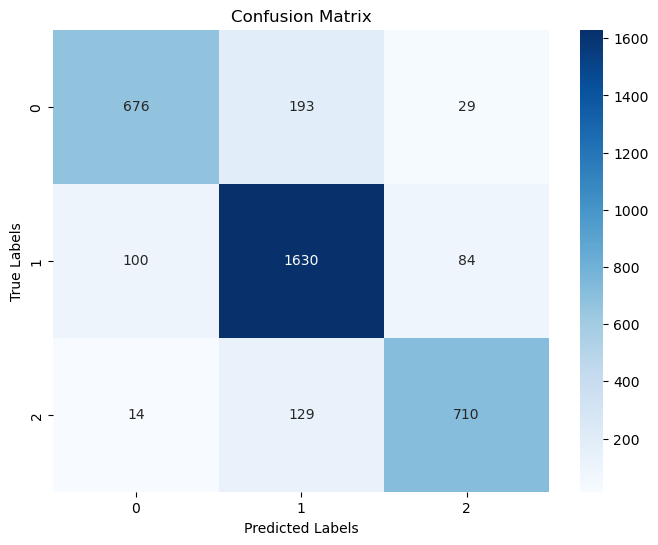

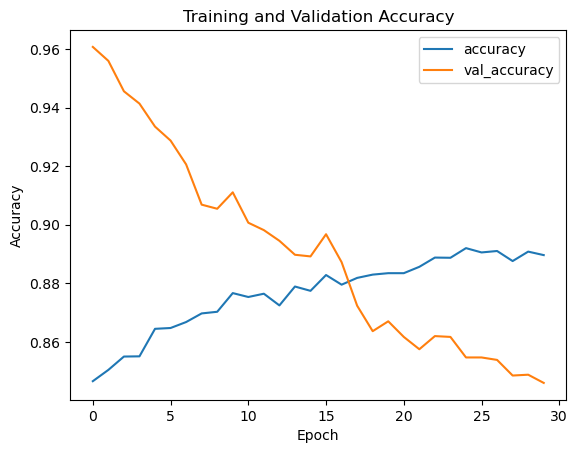

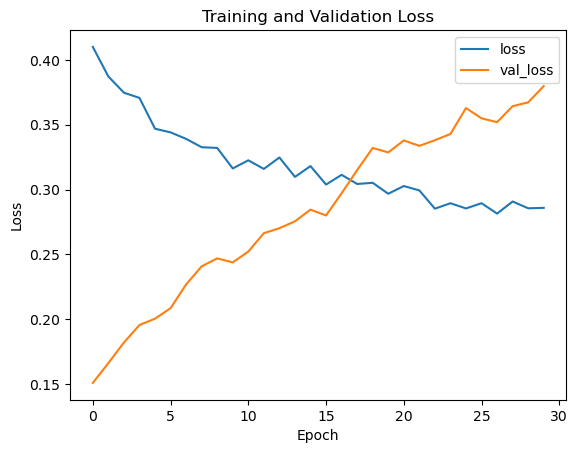

Fold 5
Epoch 1/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3807 - accuracy: 0.8592 - val_loss: 0.1278 - val_accuracy: 0.9689
Epoch 2/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3459 - accuracy: 0.8686 - val_loss: 0.1433 - val_accuracy: 0.9633
Epoch 3/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3354 - accuracy: 0.8715 - val_loss: 0.1633 - val_accuracy: 0.9475
Epoch 4/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3231 - accuracy: 0.8723 - val_loss: 0.1684 - val_accuracy: 0.9495
Epoch 5/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3157 - accuracy: 0.8746 - val_loss: 0.1806 - val_accuracy: 0.9403
Epoch 6/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3062 - accuracy: 0.8808 - val_loss: 0.1881 - val_accuracy: 0.9341
Epoch 7/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3047 - accuracy: 0.8812 - val_loss: 0.1961 - val_accuracy: 0.9318

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8642356241234221, Validation F1 Score: 0.8633052181080577, Validation Precision: 0.8668104272512791, Validation Recall: 0.8642356241234221
              precision    recall  f1-score   support

    Positive       0.88      0.81      0.84       926
    Negative       0.84      0.93      0.88      1800
     Neutral       0.90      0.80      0.85       839

    accuracy                           0.86      3565
   macro avg       0.88      0.84      0.86      3565
weighted avg       0.87      0.86      0.86      3565



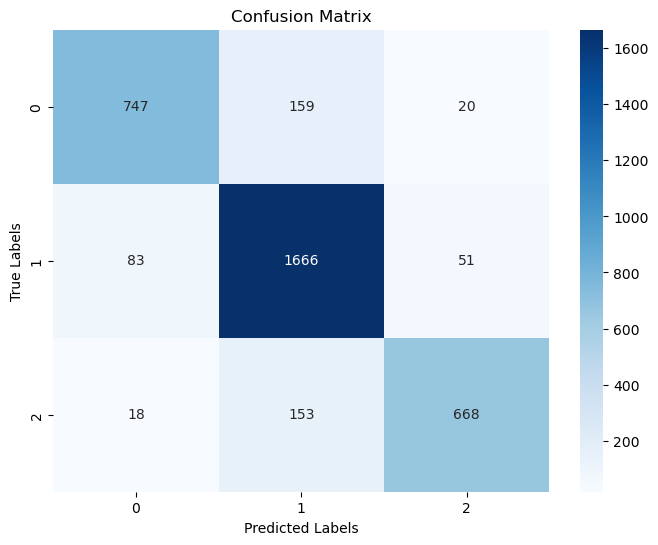

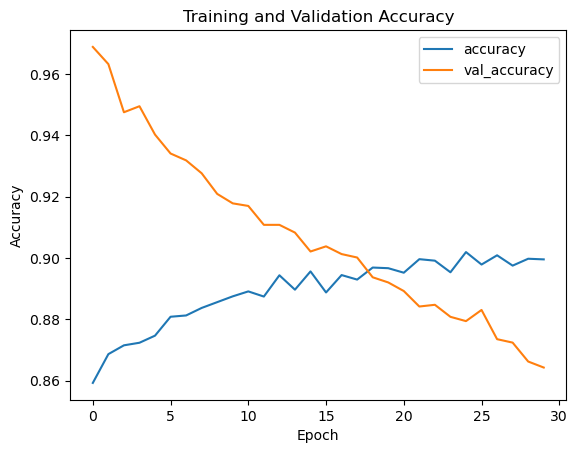

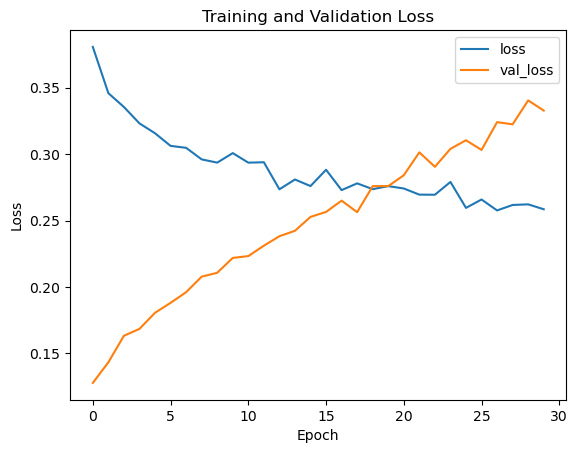

Mean Accuracy: 0.7985255321609183
Mean F1 Score: 0.7955226146382751

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.67      0.51      0.58       877
    Negative       0.72      0.82      0.77      1866
     Neutral       0.70      0.65      0.68       823

    accuracy                           0.71      3566
   macro avg       0.70      0.66      0.67      3566
weighted avg       0.70      0.71      0.70      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.77      0.61      0.68       920
    Negative       0.74      0.87      0.80      1761
     Neutral       0.80      0.69      0.74       885

    accuracy                           0.76      3566
   macro avg       0.77      0.73      0.74      3566
weighted avg       0.76      0.76      0.76      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7016264722378015, Validation F1 Score: 0.6996587214418024, Validation Precision: 0.7001821787124639, Validation Recall: 0.7016264722378015
              precision    recall  f1-score   support

    Positive       0.62      0.61      0.61       877
    Negative       0.74      0.79      0.76      1866
     Neutral       0.70      0.61      0.65       823

    accuracy                           0.70      3566
   macro avg       0.69      0.67      0.68      3566
weighted avg       0.70      0.70      0.70      3566



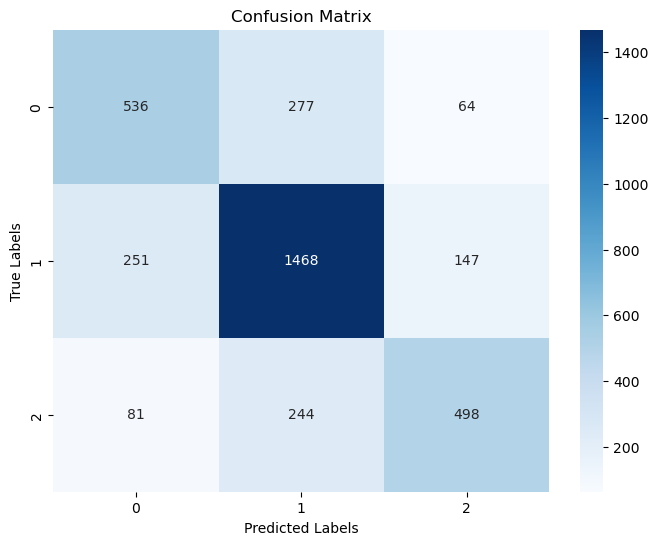

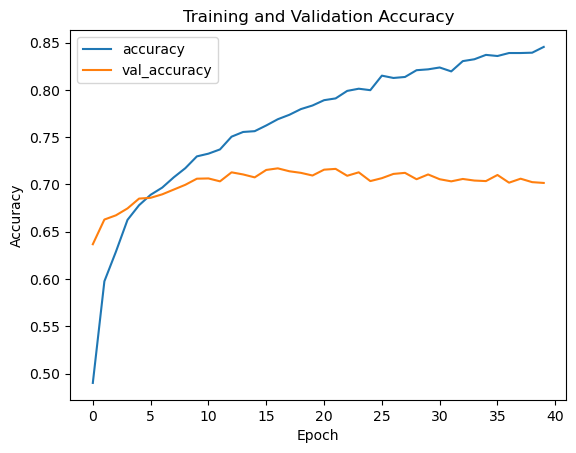

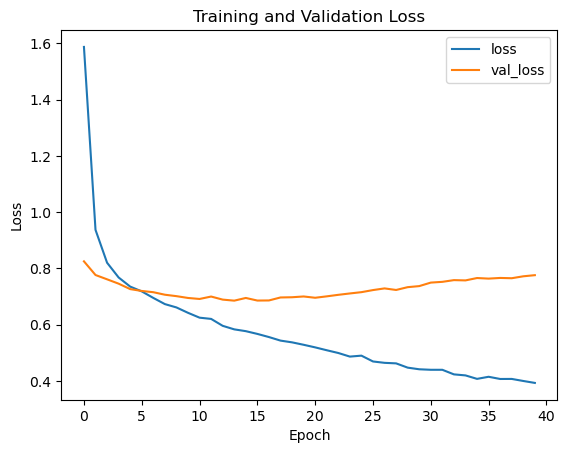

Fold 2
Epoch 1/40
223/223 [==============================] - 2s 7ms/step - loss: 0.5329 - accuracy: 0.7996 - val_loss: 0.2868 - val_accuracy: 0.8982
Epoch 2/40
223/223 [==============================] - 1s 6ms/step - loss: 0.4898 - accuracy: 0.8062 - val_loss: 0.3126 - val_accuracy: 0.8934
Epoch 3/40
223/223 [==============================] - 1s 7ms/step - loss: 0.4709 - accuracy: 0.8178 - val_loss: 0.3353 - val_accuracy: 0.8763
Epoch 4/40
223/223 [==============================] - 1s 6ms/step - loss: 0.4560 - accuracy: 0.8232 - val_loss: 0.3541 - val_accuracy: 0.8612
Epoch 5/40
223/223 [==============================] - 1s 7ms/step - loss: 0.4509 - accuracy: 0.8201 - val_loss: 0.3572 - val_accuracy: 0.8674
Epoch 6/40
223/223 [==============================] - 2s 7ms/step - loss: 0.4312 - accuracy: 0.8309 - val_loss: 0.3694 - val_accuracy: 0.8589
Epoch 7/40
223/223 [==============================] - 1s 7ms/step - loss: 0.4235 - accuracy: 0.8307 - val_loss: 0.3882 - val_accuracy: 0.8421

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7694896242288278, Validation F1 Score: 0.7653075540457628, Validation Precision: 0.7746834745169939, Validation Recall: 0.7694896242288278
              precision    recall  f1-score   support

    Positive       0.80      0.62      0.70       920
    Negative       0.75      0.88      0.81      1761
     Neutral       0.81      0.70      0.75       885

    accuracy                           0.77      3566
   macro avg       0.78      0.73      0.75      3566
weighted avg       0.77      0.77      0.77      3566



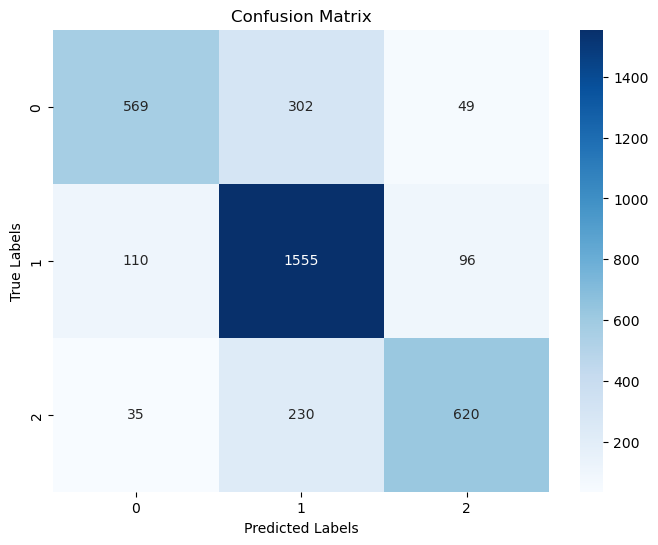

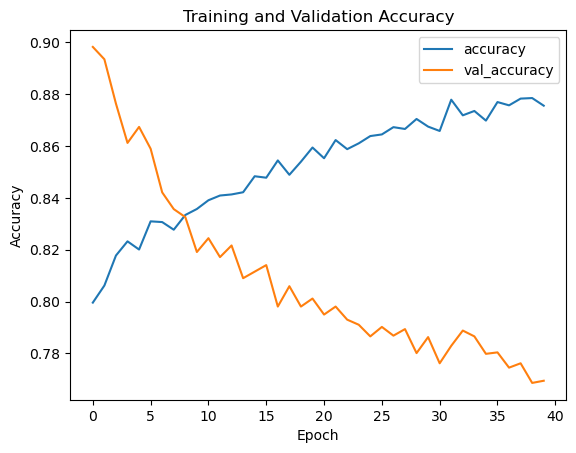

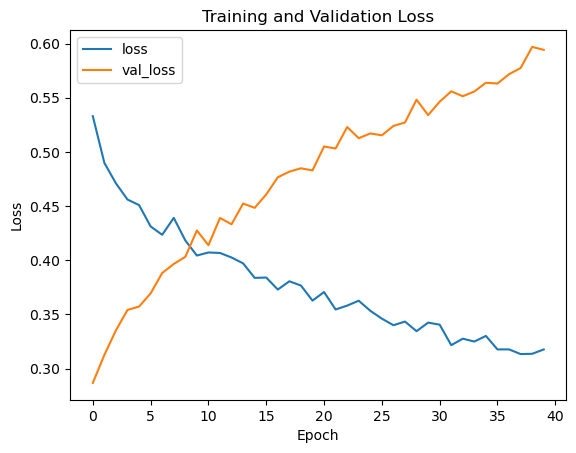

Fold 3
Epoch 1/40
223/223 [==============================] - 2s 8ms/step - loss: 0.4555 - accuracy: 0.8291 - val_loss: 0.1711 - val_accuracy: 0.9579
Epoch 2/40
223/223 [==============================] - 2s 7ms/step - loss: 0.4059 - accuracy: 0.8424 - val_loss: 0.1893 - val_accuracy: 0.9476
Epoch 3/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3898 - accuracy: 0.8470 - val_loss: 0.2083 - val_accuracy: 0.9352
Epoch 4/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3768 - accuracy: 0.8577 - val_loss: 0.2215 - val_accuracy: 0.9324
Epoch 5/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3555 - accuracy: 0.8615 - val_loss: 0.2293 - val_accuracy: 0.9291
Epoch 6/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3611 - accuracy: 0.8579 - val_loss: 0.2410 - val_accuracy: 0.9229
Epoch 7/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3564 - accuracy: 0.8622 - val_loss: 0.2572 - val_accuracy: 0.9077

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8275378575434661, Validation F1 Score: 0.825738980812295, Validation Precision: 0.829303722064624, Validation Recall: 0.8275378575434661
              precision    recall  f1-score   support

    Positive       0.82      0.73      0.78       932
    Negative       0.81      0.91      0.86      1806
     Neutral       0.87      0.77      0.81       828

    accuracy                           0.83      3566
   macro avg       0.84      0.80      0.82      3566
weighted avg       0.83      0.83      0.83      3566



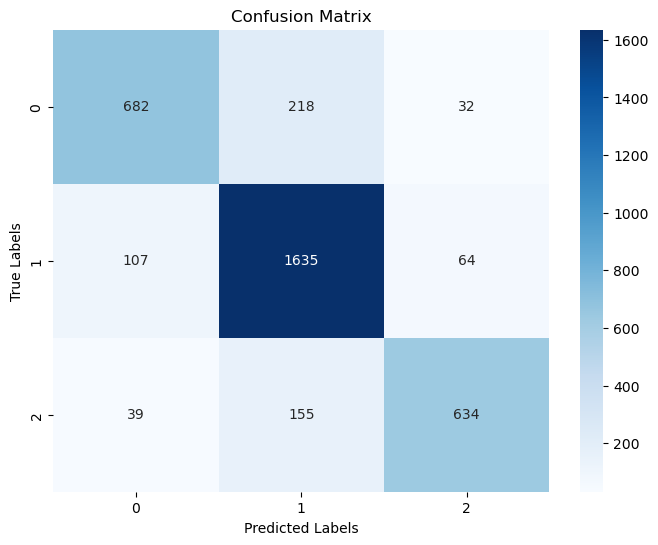

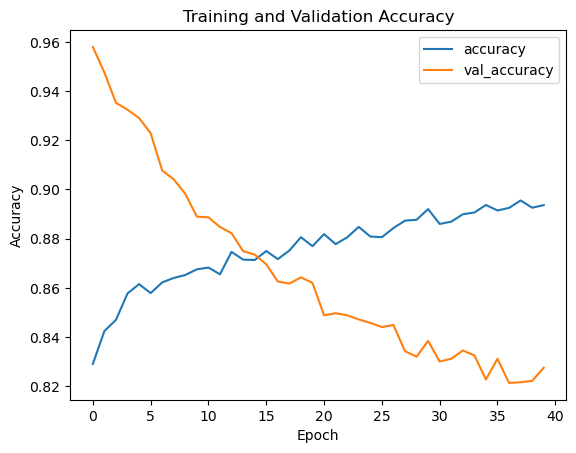

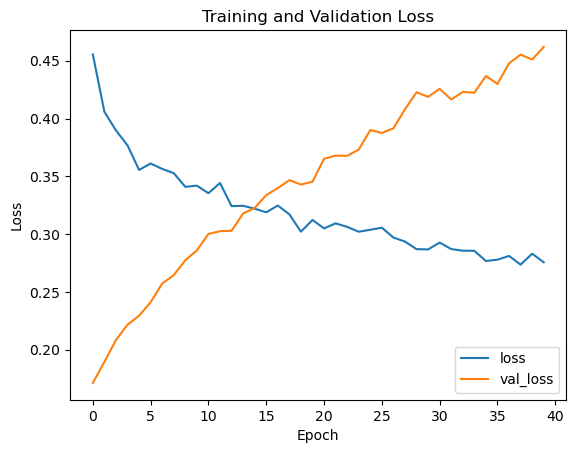

Fold 4
Epoch 1/40
223/223 [==============================] - 2s 8ms/step - loss: 0.3898 - accuracy: 0.8565 - val_loss: 0.1204 - val_accuracy: 0.9705
Epoch 2/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3741 - accuracy: 0.8564 - val_loss: 0.1469 - val_accuracy: 0.9546
Epoch 3/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3427 - accuracy: 0.8692 - val_loss: 0.1519 - val_accuracy: 0.9546
Epoch 4/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3285 - accuracy: 0.8729 - val_loss: 0.1679 - val_accuracy: 0.9470
Epoch 5/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3200 - accuracy: 0.8767 - val_loss: 0.1689 - val_accuracy: 0.9445
Epoch 6/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3168 - accuracy: 0.8793 - val_loss: 0.1770 - val_accuracy: 0.9383
Epoch 7/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3014 - accuracy: 0.8846 - val_loss: 0.1831 - val_accuracy: 0.9324

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8605890603085554, Validation F1 Score: 0.8592565665473282, Validation Precision: 0.8623458976849857, Validation Recall: 0.8605890603085554
              precision    recall  f1-score   support

    Positive       0.87      0.76      0.81       898
    Negative       0.84      0.92      0.88      1814
     Neutral       0.89      0.84      0.86       853

    accuracy                           0.86      3565
   macro avg       0.87      0.84      0.85      3565
weighted avg       0.86      0.86      0.86      3565



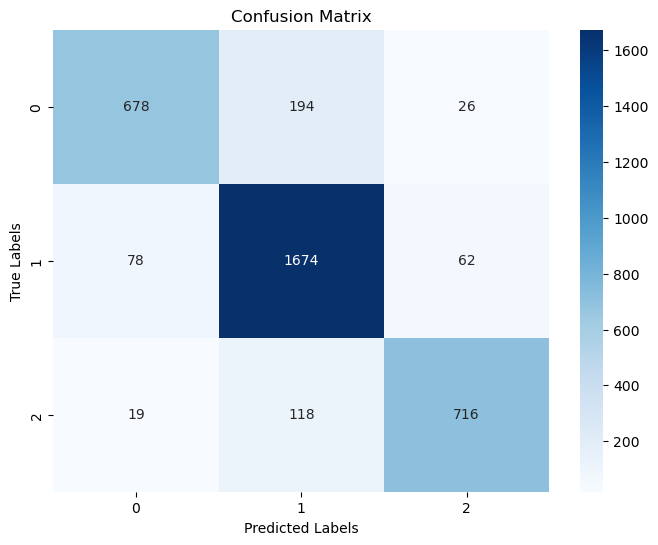

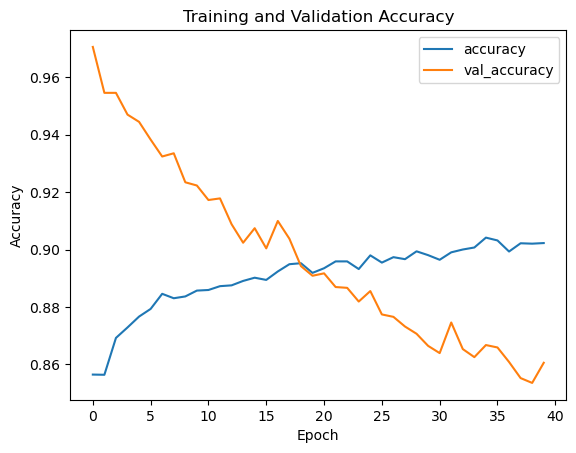

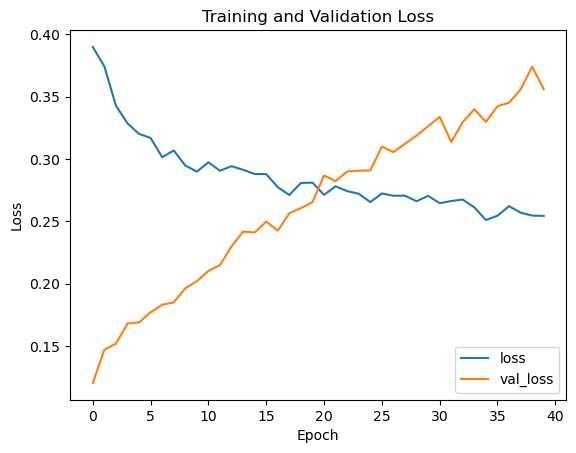

Fold 5
Epoch 1/40
223/223 [==============================] - 2s 8ms/step - loss: 0.3613 - accuracy: 0.8663 - val_loss: 0.1100 - val_accuracy: 0.9703
Epoch 2/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3294 - accuracy: 0.8754 - val_loss: 0.1259 - val_accuracy: 0.9661
Epoch 3/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3046 - accuracy: 0.8820 - val_loss: 0.1351 - val_accuracy: 0.9582
Epoch 4/40
223/223 [==============================] - 2s 7ms/step - loss: 0.2994 - accuracy: 0.8845 - val_loss: 0.1366 - val_accuracy: 0.9579
Epoch 5/40
223/223 [==============================] - 2s 7ms/step - loss: 0.2859 - accuracy: 0.8913 - val_loss: 0.1422 - val_accuracy: 0.9562
Epoch 6/40
223/223 [==============================] - 2s 7ms/step - loss: 0.2863 - accuracy: 0.8918 - val_loss: 0.1537 - val_accuracy: 0.9498
Epoch 7/40
223/223 [==============================] - 2s 7ms/step - loss: 0.2775 - accuracy: 0.8918 - val_loss: 0.1633 - val_accuracy: 0.9411

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8760168302945301, Validation F1 Score: 0.8753229850560174, Validation Precision: 0.8774243242238143, Validation Recall: 0.8760168302945301
              precision    recall  f1-score   support

    Positive       0.89      0.82      0.86       926
    Negative       0.86      0.93      0.89      1800
     Neutral       0.90      0.82      0.86       839

    accuracy                           0.88      3565
   macro avg       0.88      0.86      0.87      3565
weighted avg       0.88      0.88      0.88      3565



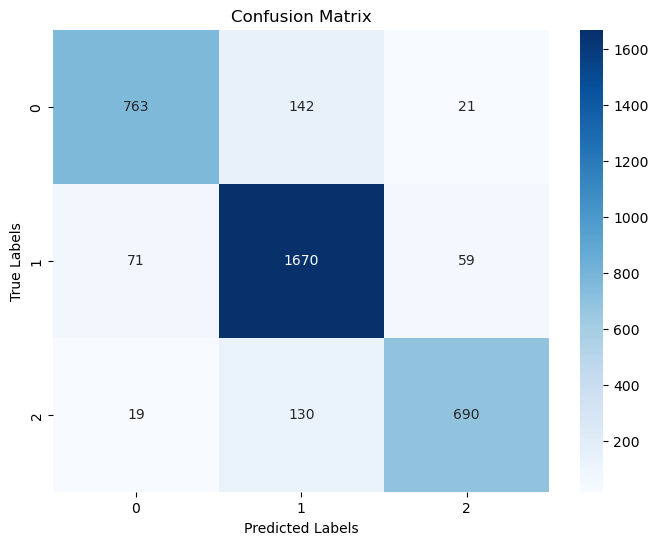

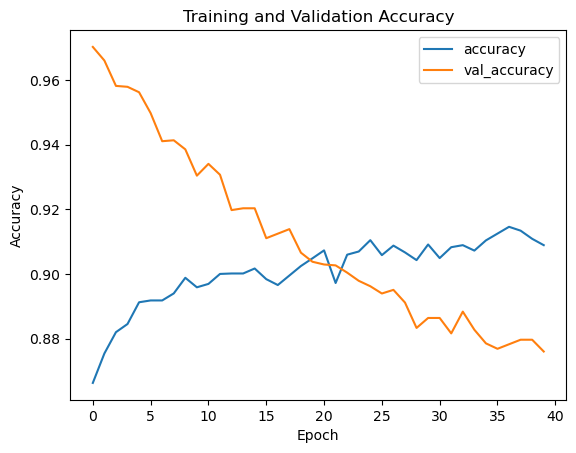

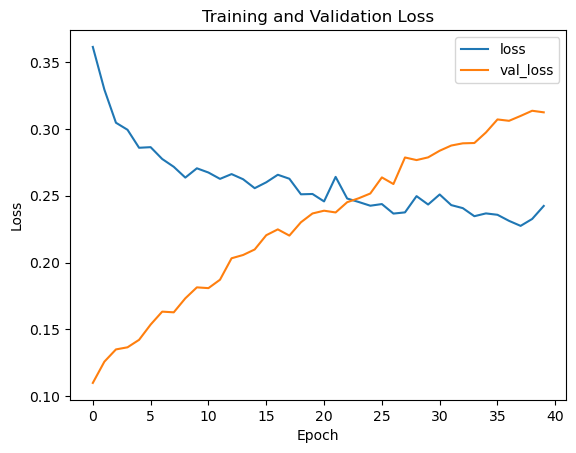

Mean Accuracy: 0.8070519689226362
Mean F1 Score: 0.8050569615806413

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.62      0.61      0.61       877
    Negative       0.74      0.79      0.76      1866
     Neutral       0.70      0.61      0.65       823

    accuracy                           0.70      3566
   macro avg       0.69      0.67      0.68      3566
weighted avg       0.70      0.70      0.70      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.80      0.62      0.70       920
    Negative       0.75      0.88      0.81      1761
     Neutral       0.81      0.70      0.75       885

    accuracy                           0.77      3566
   macro avg       0.78      0.73      0.75      3566
weighted avg       0.77      0.77      0.77      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

223/223 [==============================] - 2s 7ms/step - loss: 0.3962 - accuracy: 0.8432 - val_loss: 0.7583 - val_accuracy: 0.7187
Epoch 42/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4010 - accuracy: 0.8393 - val_loss: 0.7604 - val_accuracy: 0.7156
Epoch 43/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3843 - accuracy: 0.8460 - val_loss: 0.7645 - val_accuracy: 0.7165
Epoch 44/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3842 - accuracy: 0.8460 - val_loss: 0.7764 - val_accuracy: 0.7142
Epoch 45/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3790 - accuracy: 0.8514 - val_loss: 0.7792 - val_accuracy: 0.7170
Epoch 46/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3765 - accuracy: 0.8507 - val_loss: 0.7911 - val_accuracy: 0.7114
Epoch 47/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3691 - accuracy: 0.8534 - val_loss: 0.7850 - val_accuracy: 0.7173
Epoch 48/50

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7106001121704991, Validation F1 Score: 0.7086039592978203, Validation Precision: 0.7084576022584886, Validation Recall: 0.7106001121704991
              precision    recall  f1-score   support

    Positive       0.64      0.60      0.62       877
    Negative       0.74      0.79      0.77      1866
     Neutral       0.71      0.64      0.68       823

    accuracy                           0.71      3566
   macro avg       0.70      0.68      0.69      3566
weighted avg       0.71      0.71      0.71      3566



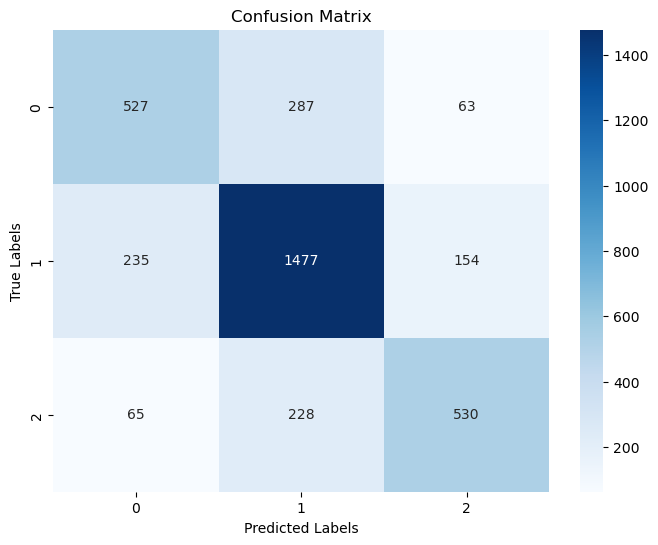

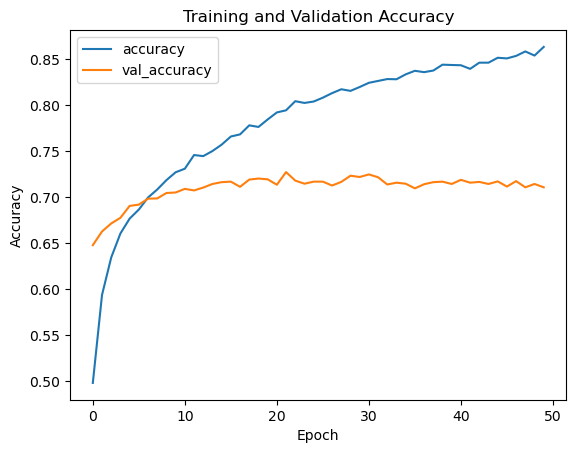

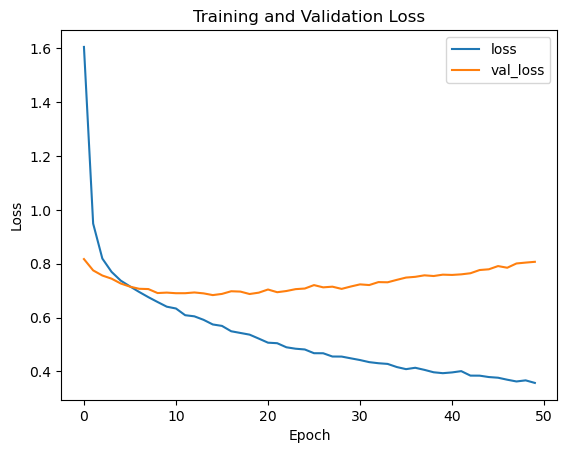

Fold 2
Epoch 1/50
223/223 [==============================] - 2s 8ms/step - loss: 0.5235 - accuracy: 0.8087 - val_loss: 0.2522 - val_accuracy: 0.9209
Epoch 2/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4728 - accuracy: 0.8213 - val_loss: 0.2821 - val_accuracy: 0.9105
Epoch 3/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4491 - accuracy: 0.8262 - val_loss: 0.2996 - val_accuracy: 0.8951
Epoch 4/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4311 - accuracy: 0.8317 - val_loss: 0.3058 - val_accuracy: 0.8960
Epoch 5/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4204 - accuracy: 0.8368 - val_loss: 0.3279 - val_accuracy: 0.8772
Epoch 6/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4205 - accuracy: 0.8320 - val_loss: 0.3336 - val_accuracy: 0.8688
Epoch 7/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4141 - accuracy: 0.8358 - val_loss: 0.3506 - val_accuracy: 0.8609

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7703309029725183, Validation F1 Score: 0.7680365882173545, Validation Precision: 0.7719797546684417, Validation Recall: 0.7703309029725183
              precision    recall  f1-score   support

    Positive       0.75      0.66      0.70       920
    Negative       0.76      0.86      0.81      1761
     Neutral       0.82      0.71      0.76       885

    accuracy                           0.77      3566
   macro avg       0.78      0.74      0.76      3566
weighted avg       0.77      0.77      0.77      3566



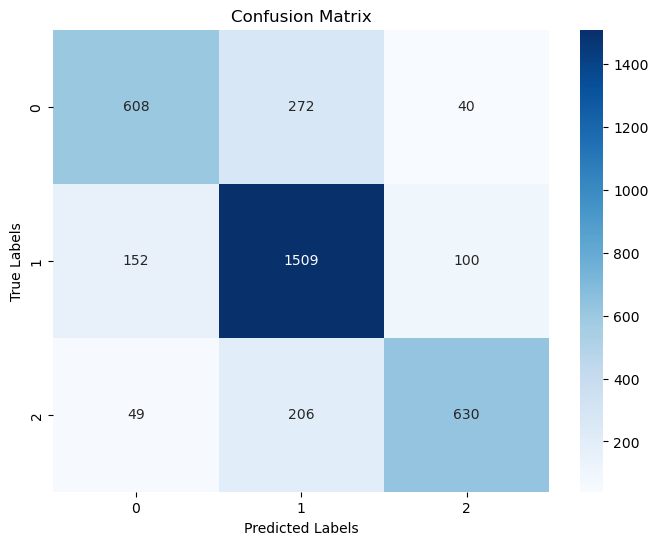

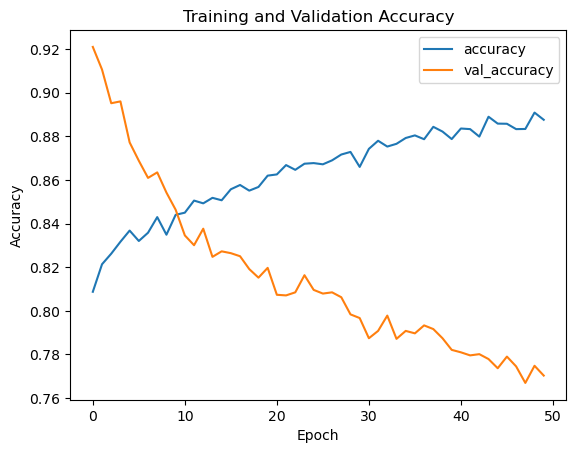

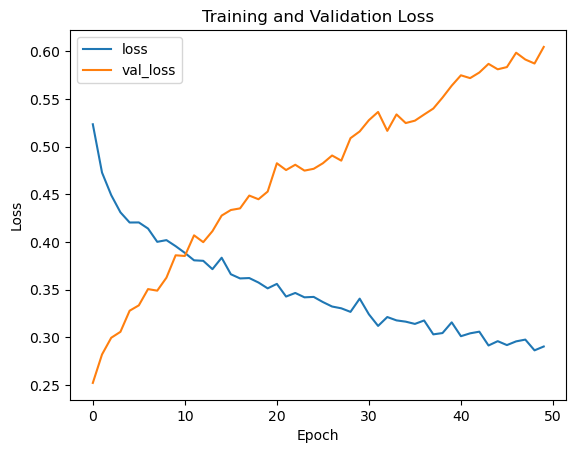

Fold 3
Epoch 1/50
223/223 [==============================] - 2s 8ms/step - loss: 0.4448 - accuracy: 0.8371 - val_loss: 0.1508 - val_accuracy: 0.9644
Epoch 2/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3881 - accuracy: 0.8509 - val_loss: 0.1749 - val_accuracy: 0.9540
Epoch 3/50
223/223 [==============================] - 2s 8ms/step - loss: 0.3713 - accuracy: 0.8591 - val_loss: 0.1891 - val_accuracy: 0.9405
Epoch 4/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3546 - accuracy: 0.8582 - val_loss: 0.2005 - val_accuracy: 0.9414
Epoch 5/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3500 - accuracy: 0.8638 - val_loss: 0.2125 - val_accuracy: 0.9316
Epoch 6/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3343 - accuracy: 0.8685 - val_loss: 0.2238 - val_accuracy: 0.9187
Epoch 7/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3334 - accuracy: 0.8735 - val_loss: 0.2306 - val_accuracy: 0.9153

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 3ms/step
Validation Accuracy: 0.8286595625350532, Validation F1 Score: 0.8265033273540626, Validation Precision: 0.8309710201256794, Validation Recall: 0.8286595625350532
              precision    recall  f1-score   support

    Positive       0.83      0.73      0.77       932
    Negative       0.81      0.91      0.86      1806
     Neutral       0.87      0.76      0.81       828

    accuracy                           0.83      3566
   macro avg       0.84      0.80      0.82      3566
weighted avg       0.83      0.83      0.83      3566



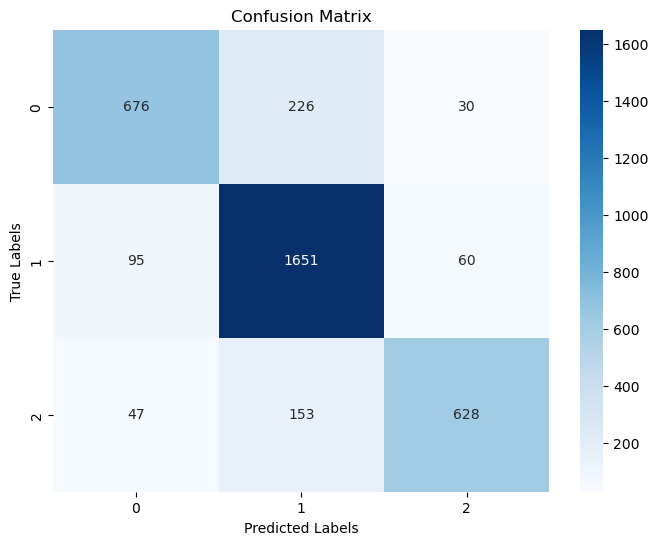

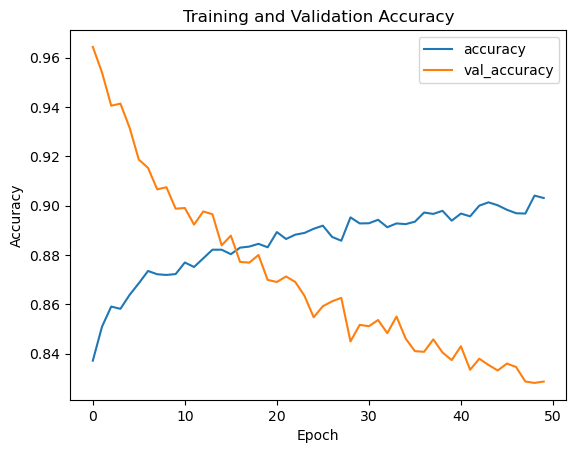

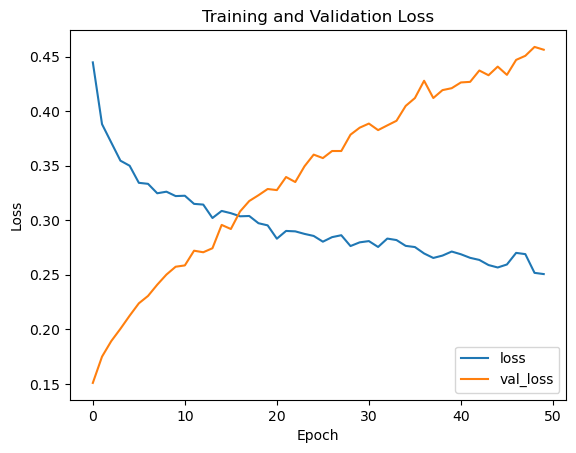

Fold 4
Epoch 1/50
223/223 [==============================] - 2s 8ms/step - loss: 0.3834 - accuracy: 0.8621 - val_loss: 0.1097 - val_accuracy: 0.9711
Epoch 2/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3456 - accuracy: 0.8696 - val_loss: 0.1306 - val_accuracy: 0.9627
Epoch 3/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3327 - accuracy: 0.8722 - val_loss: 0.1312 - val_accuracy: 0.9613
Epoch 4/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3243 - accuracy: 0.8744 - val_loss: 0.1444 - val_accuracy: 0.9590
Epoch 5/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2999 - accuracy: 0.8824 - val_loss: 0.1474 - val_accuracy: 0.9551
Epoch 6/50
223/223 [==============================] - 2s 8ms/step - loss: 0.2986 - accuracy: 0.8852 - val_loss: 0.1587 - val_accuracy: 0.9447
Epoch 7/50
223/223 [==============================] - 2s 8ms/step - loss: 0.2942 - accuracy: 0.8886 - val_loss: 0.1607 - val_accuracy: 0.9520

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8535764375876578, Validation F1 Score: 0.8522811076274571, Validation Precision: 0.8556001967337424, Validation Recall: 0.8535764375876578
              precision    recall  f1-score   support

    Positive       0.87      0.77      0.81       898
    Negative       0.84      0.92      0.88      1814
     Neutral       0.89      0.80      0.84       853

    accuracy                           0.85      3565
   macro avg       0.86      0.83      0.84      3565
weighted avg       0.86      0.85      0.85      3565



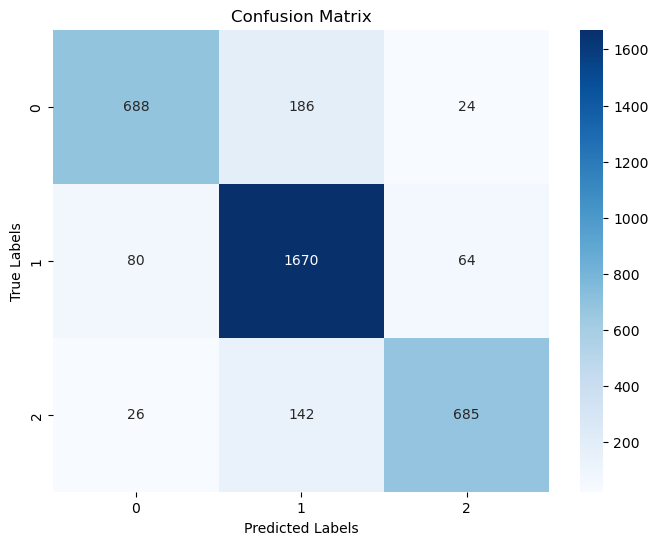

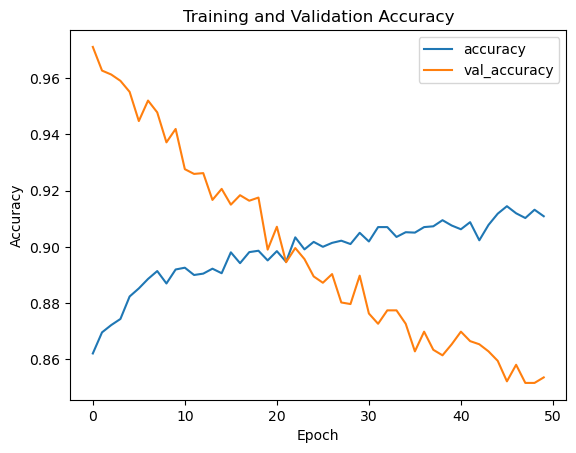

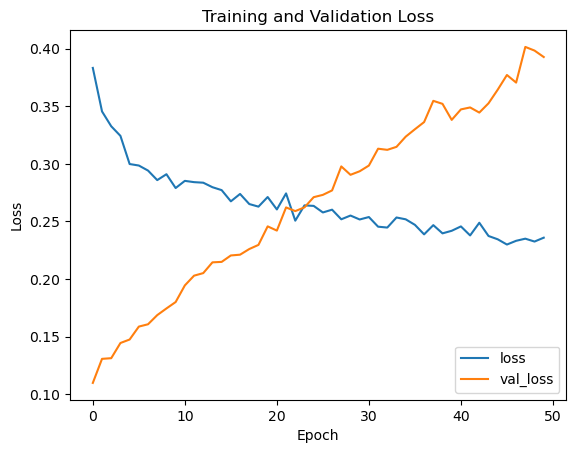

Fold 5
Epoch 1/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3608 - accuracy: 0.8760 - val_loss: 0.0933 - val_accuracy: 0.9776
Epoch 2/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3265 - accuracy: 0.8814 - val_loss: 0.1085 - val_accuracy: 0.9714
Epoch 3/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2935 - accuracy: 0.8854 - val_loss: 0.1146 - val_accuracy: 0.9686
Epoch 4/50
223/223 [==============================] - 1s 7ms/step - loss: 0.2878 - accuracy: 0.8913 - val_loss: 0.1179 - val_accuracy: 0.9683
Epoch 5/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2712 - accuracy: 0.8940 - val_loss: 0.1298 - val_accuracy: 0.9652
Epoch 6/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2758 - accuracy: 0.8937 - val_loss: 0.1372 - val_accuracy: 0.9582
Epoch 7/50
223/223 [==============================] - 1s 7ms/step - loss: 0.2642 - accuracy: 0.8995 - val_loss: 0.1413 - val_accuracy: 0.9571

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8650771388499299, Validation F1 Score: 0.864230842516384, Validation Precision: 0.8669367501447424, Validation Recall: 0.8650771388499299
              precision    recall  f1-score   support

    Positive       0.88      0.79      0.83       926
    Negative       0.85      0.92      0.88      1800
     Neutral       0.90      0.82      0.86       839

    accuracy                           0.87      3565
   macro avg       0.87      0.85      0.86      3565
weighted avg       0.87      0.87      0.86      3565



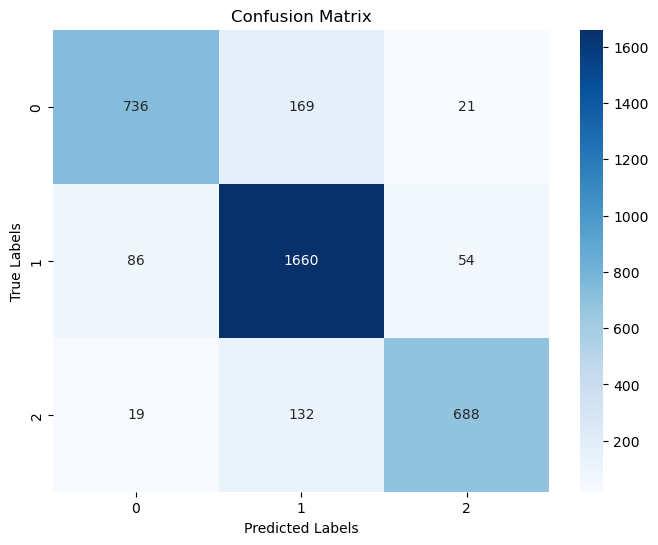

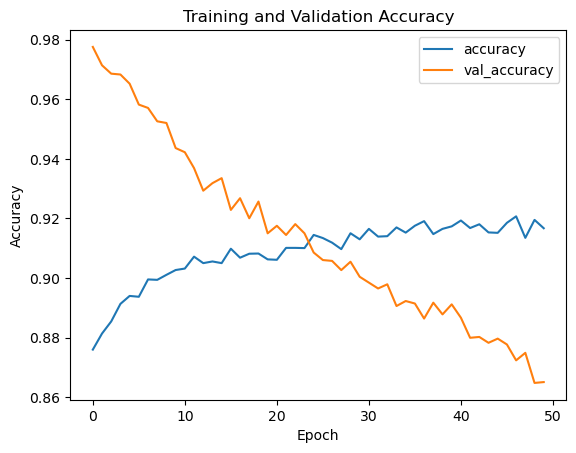

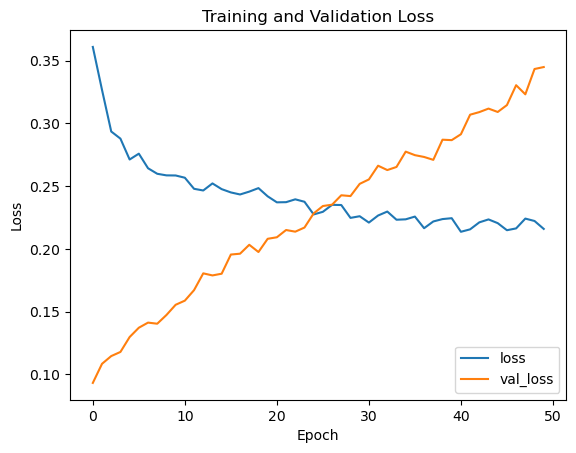

Mean Accuracy: 0.8056488308231318
Mean F1 Score: 0.8039311650026157

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.64      0.60      0.62       877
    Negative       0.74      0.79      0.77      1866
     Neutral       0.71      0.64      0.68       823

    accuracy                           0.71      3566
   macro avg       0.70      0.68      0.69      3566
weighted avg       0.71      0.71      0.71      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.75      0.66      0.70       920
    Negative       0.76      0.86      0.81      1761
     Neutral       0.82      0.71      0.76       885

    accuracy                           0.77      3566
   macro avg       0.78      0.74      0.76      3566
weighted avg       0.77      0.77      0.77      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from graphviz import Digraph
from sklearn.metrics import precision_score

def create_model(embedding_dim=100, num_filters=128, filter_sizes=[3], dropout_rate=0.5):
    input_layer = Input(shape=(max_len,))
    
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                                output_dim=embedding_dim, 
                                input_length=max_len,
                                weights=[embedding_matrix], 
                                trainable=False)(input_layer)
    
    conv_layers = []
    for filter_size in filter_sizes:
        conv_layer = Conv1D(num_filters, filter_size, activation='relu')(embedding_layer)
        conv_layers.append(conv_layer)
    
    if len(conv_layers) > 1:
        merged = concatenate(conv_layers, axis=-1)
    else:
        merged = conv_layers[0]
    
    pooling_layer = GlobalMaxPooling1D()(merged)
    
    dropout_layer = Dropout(dropout_rate)(pooling_layer)
    
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Start Modeling
model = create_model()

# Start Modeling
best_model_metrics = {
    'f1_score': 0,
    'precision': 0,
    'accuracy': 0,
    'recall': 0,
    'support': 0,
    'model': None,
    'epoch': 0
}

for epoch in range(10, 51, 10):
    print(f'Epochs: {epoch}')


    accuracy_scores = []
    f1_scores = []
    precisions = []
    recalls = []
    classification_reports = []  # Store classification reports for each fold

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(text, y), 1):
        print(f'Fold {fold}')

        X_train, X_val = text[train_indices], text[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        model = create_model()

        # Train model or load model from the previous fold
        if fold > 1:
            model = load_model(f"model_fold{fold - 1}.h5")

        # Train model
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=64, validation_data=(X_val, y_val))
        model.save(f"model_fold{fold}.h5")


        # Evaluate model
        y_pred = np.argmax(model.predict(X_val), axis=1)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        precision = precision_score(y_val, y_pred, average='weighted')  # Add this line for precision
        recall = recall_score(y_val, y_pred, average='weighted')  # Add this line for recall
        support = len(y_val)  # Add this line for support
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        precisions.append(precision)  # Add precision to the list
        recalls.append(recall)  # Add recall to the list
        print(f"Validation Accuracy: {accuracy}, Validation F1 Score: {f1}, Validation Precision: {precision}, Validation Recall: {recall}")



        # Generate classification report with labels
        report = classification_report(y_val, y_pred, labels=[0, 1, 2], target_names=['Positive', 'Negative', 'Neutral'])
        classification_reports.append(report)
        print(report)

        # Plot confusion matrix, save plots, and show
        plot_confusion_matrix(y_val, y_pred, labels=[0, 1, 2])

        # Plot training history, save plots, and show
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        # Generate flowchart
        dot = Digraph(comment='Model Flowchart')
        dot.node('A', 'Input')
        dot.node('B', 'Embedding')
        dot.node('C', 'Conv1D')
        dot.node('D', 'GlobalMaxPooling1D')
        dot.node('E', 'Dropout')
        dot.node('F', 'Dense')

        dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])
        dot.render(f'flowchart_fold{fold}', format='png', cleanup=True)

    # Print mean evaluation metrics across all folds
    print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
    print(f'Mean F1 Score: {np.mean(f1_scores)}')

    # Print the classification reports for each fold
    for idx, report in enumerate(classification_reports, 1):
        print(f"\nFold {idx} Classification Report:")
        print(report)

    # Compare with best model so far
        if f1 > best_model_metrics['f1_score'] or \
                (f1 == best_model_metrics['f1_score'] and accuracy > best_model_metrics['accuracy']) or \
                (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                 precision > best_model_metrics['precision']) or \
                (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                 precision == best_model_metrics['precision'] and recall > best_model_metrics['recall']) or \
                (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                 precision == best_model_metrics['precision'] and recall == best_model_metrics['recall'] and
                 support > best_model_metrics['support']):
            best_model_metrics['f1_score'] = f1
            best_model_metrics['precision'] = precision
            best_model_metrics['accuracy'] = accuracy
            best_model_metrics['recall'] = recall
            best_model_metrics['support'] = support
            best_model_metrics['model'] = model
            best_model_metrics['epoch'] = epoch

    print(f'Best Model Metrics for Epoch {epoch}:')
    print(best_model_metrics)

# Save the best model
best_model_metrics['model'].save(f"best_model_epoch_{best_model_metrics['epoch']}.h5")
print(f'Best model saved as: best_model_epoch_{best_model_metrics["epoch"]}.h5')

In [ ]:
data = pd.read_csv('dataset_roberta_Cardiffnlp.csv',delimiter=';')
data

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
sentimen_negatif = data[data['label'] == 'negative']['text'].str.cat(sep=' ')
sentimen_positif = data[data['label'] == 'positive']['text'].str.cat(sep=' ')
sentimen_netral = data[data['label'] == 'neutral']['text'].str.cat(sep=' ')

In [ ]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_negatif, 'WordCloud Sentimen Negatif')

In [ ]:
# Membuat WordCloud untuk sentimen positif
create_wordcloud(sentimen_positif, 'WordCloud Sentimen Positif')

In [ ]:
# Membuat WordCloud untuk sentimen netral
create_wordcloud(sentimen_netral, 'WordCloud Sentimen Netral')